# Single cell evaluation of co-regulated genes

This notebook aims to evaluate the co-expression of genes identified to be co-regulated in the CPTAC dataset (https://www.sciencedirect.com/science/article/pii/S0092867419311237), a dataset of 110 patients and protein, RNAseq and DNA methylation data. We're looking at a form of Kidney cancer (ccRCC) clear cell renal cell carcinoma. This affects alot of people (ths most common form of kidney cancer). It is an interesting cancer because of the metabolic rewiring that the cells undergo, in addition of aberant DNA hyper methylation. We're aiming to see if by identifiying co-regulated genes, we can work out on which level they are best targetted with drugs. The first part of the paper was identifying the regulatory groups based on changes in tumour vs normal. The second part is identifying which of these genes change between early and late stage patients. We're interested in using the single cell data to determine whether the genes that change in late and early stage are co-expressed at the single cell level (and then likely to be actually in those cancer cells working together at least that is what we're using this evidence to suggest.)


The single cell data comes from: 
https://www.sciencedirect.com/science/article/pii/S1535610821001653?via%3Dihub 
- Single-cell RNA-seq reveals the architecture of the ccRCC immune microenvironment  
- Multiregional immune phenotypes integrated with bulk RNA-seq and tumor pathology  
- TCR usage varies by phenotype and defines T cell differentiation trajectories  
- Signatures of tissue-resident T cells and TAMs predict clinical outcome  

#### Summary from single cell paper:  
Clear cell renal cell carcinomas (ccRCCs) are highly immune infiltrated, but the effect of immune heterogeneity on clinical outcome in ccRCC has not been fully characterized. Here we perform paired single-cell RNA (scRNA) and T cell receptor (TCR) sequencing of 167,283 cells from multiple tumor regions, lymph node, normal kidney, and peripheral blood of two immune checkpoint blockade (ICB)-naïve and four ICB-treated patients to map the ccRCC immune landscape. We detect extensive heterogeneity within and between patients, with enrichment of CD8A+ tissue-resident T cells in a patient responsive to ICB and tumor-associated macrophages (TAMs) in a resistant patient. A TCR trajectory framework suggests distinct T cell differentiation pathways between patients responding and resistant to ICB. Finally, scRNA-derived signatures of tissue-resident T cells and TAMs are associated with response to ICB and targeted therapies across multiple independent cohorts. Our study establishes a multimodal interrogation of the cellular programs underlying therapeutic efficacy in ccRCC.

#### Figure 2 
Mainly we're interested in the UMAP from Figure 2: Immune landscape of patients with ccRCC at single-cell resolution

(A) UMAP embedding of transcriptional profiles from all patients and samples (n = 167,283). Each dot represents a single cell, and colors represent clusters denoted by inferred cell type.  


#### Data details
Data were downloaded from https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?analysis=SRZ190804 

```
ccRCC_6pat_Seurat	23.4Gb	2021-03-26 10:51:14	c26b3e222bcf6d1f40ef9112864bc9f7
ccRCC_6pat_cell_annotations.txt	20.2Mb	2021-03-26 10:54:30	9c8f646ec8a1f54fa97c2f1524d505b3
ccRCC_TCRs.txt	3.7Mb	2021-03-26 10:54:31	204982b821836f39950627a642218f9f
ccRCC_regions.txt	348b	2021-03-26 10:54:32	af230043d451b477dc44386a0d26d075
```
and then saved to csv's using the following R script:

```
library(Seurat)
library(SeuratData)
library(loomR)
library(tidyverse)
library('Matrix')

devtools::install_github(repo = 'hhoeflin/hdf5r') # Update hdf5r for stability improvements
devtools::install_github(repo = 'mojaveazure/loomR', ref = 'develop') # Update loomR for up-to-date functions

install.packages('SeuratDisk')

singleCell <- readRDS('/Users/ariane/Downloads/ccRCC_6pat_Seurat')
kidney_cc <- UpdateSeuratObject(object = singleCell)

tsne_red <- kidney_cc@reductions[['tsne']]
rna_counts <- kidney_cc@assays[["RNA"]]@counts

writeMM(rna_counts,file='rna_counts_ccRCC_6pat_Seurat.txt')

gene_ids <- kidney_cc@assays[["RNA"]]@counts@Dimnames[[1]]
write.csv(gene_ids, 'geneids_ccRCC_6pat_Seurat.csv')

meta_data <- kidney_cc@meta.data
meta_data <- as.data.frame(meta_data)
write.csv(meta_data, 'metadata_ccRCC_6pat_Seurat.csv')

tsne_red <- kidney_cc@reductions[['tsne']]
tsne_red <- as.data.frame(tsne_red@cell.embeddings)
write.csv(tsne_red, 'tsne_red_ccRCC_6pat_Seurat.csv')

umap_red <- kidney_cc@reductions[['umap']]
umap_red <- as.data.frame(umap_red@cell.embeddings)
write.csv(umap_red, 'umap_red_ccRCC_6pat_Seurat.csv')

```

In [1]:
#! pip install anndata scanpy

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.io import mmread
from collections import defaultdict
import importlib as imp
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib
from scanpy import AnnData


base_dir = '../data/'
output_dir = f'{base_dir}sircle/F7_single_cell/'
data_dir = f'{base_dir}raw_downloads/single_cell/'
input_data_dir = f'{base_dir}sircle/F6_integrative_comparisons/'
save_fig = False
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'


In [3]:
################################################################################
                        # Loading the data #
################################################################################

reload_data = False
if reload_data:
    # Below compiled all the data into single AnnData, for fast/easy read/write
    counts = mmread(f'{data_dir}rna_counts_ccRCC_6pat_Seurat.txt')
    # This is not relevant, actually.
    cell_annots = pd.read_csv(f'{data_dir}ccRCC_6pat_cell_annotations.txt',
                              index_col=0, sep='\t')
    #meta = pd.concat([meta, cell_annots], axis=1)
    meta = cell_annots
    tsne = pd.read_csv(f'{data_dir}tsne_red_ccRCC_6pat_Seurat.csv', index_col=0)
    umap = pd.read_csv(f'{data_dir}umap_red_ccRCC_6pat_Seurat.csv', index_col=0)
    gene_names = pd.read_csv(f'{data_dir}geneids_ccRCC_6pat_Seurat.csv',
                             index_col=0)
    for df in [tsne, umap]:
        print(np.all(meta.index.values==df.index.values)) # All True!

    counts_frame = pd.DataFrame.sparse.from_spmatrix(counts,
                                           index=gene_names.values[:,0].astype(str),
                                  columns=meta.index.values.astype(str)).transpose()

    # Read in the output from our analysis

    ##### Creating AnnData for fast read/write access #######
    data = AnnData(counts_frame, obs=meta)
    data.obsm['X_umap'] = umap.values
    data.obsm['X_tsne'] = tsne.values

    ###### Need to convert all string annotations to categorical to get save to work
    #### TODO NOTE: Not necesary, error *was* due to duplicate columns in meta
    new_obs = data.obs
    for col in new_obs.columns:
        if new_obs[col].dtype == 'O':
            new_vals = new_obs[col].values.astype(str)
            new_obs[col] = new_vals
            new_obs[col] = new_obs[col].astype('category')
    data.obs = new_obs

    ###### Saving AnnData!
    data.write_h5ad(data_dir+'ccRCC.h5ad', compression='gzip')


In [4]:
data = sc.read_h5ad(data_dir+'ccRCC.h5ad')

In [5]:
cell_annots = pd.read_csv(f'{data_dir}ccRCC_6pat_cell_annotations.txt',
                          index_col=0, sep='\t')
len(list(set(cell_annots.cluster_name)))

31

## Visualise the loaded data

(167283, 16323)


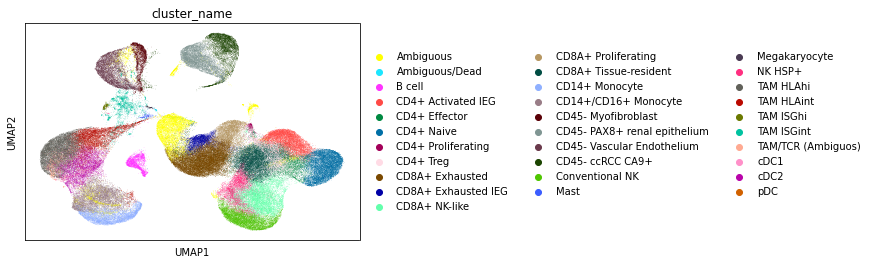

In [6]:
print(data.shape) #cells by genes
sc.pl.umap(data, color='cluster_name')

### Loading the gene modules


MDS 2 1 1.26925235 -1.4879704
MDS_TMDE 49 8 0.58025414 -0.8708036
MDE 0 2 nan -1.2964739
MDE_TMDS 162 26 0.610698075 -0.68764185
TMDE 23 7 0.8885946 -1.031239
TMDS 29 3 1.2288947 -1.3339274
TPDE 1 13 0.95921123 -1.2569926
TPDE_TMDS 117 15 0.57853997 -0.7242036
TPDS 9 3 1.3462479 -1.1079198
TPDS_TMDE 146 14 0.602266105 -0.80887113


MDS 2 1 1.26925235 -1.4879704
MDS_TMDE 37 8 0.69926214 -0.8708036
MDE 0 2 nan -1.2964739
MDE_TMDS 98 26 0.94831868 -0.68764185
TMDE 23 7 0.8885946 -1.031239
TMDS 29 3 1.2288947 -1.3339274
TPDE 1 13 0.95921123 -1.2569926
TPDE_TMDS 70 15 0.80569685 -0.7242036
TPDS 9 3 1.3462479 -1.1079198
TPDS_TMDE 97 14 0.69960546 -0.80887113

## Calling DE for the gene modules using One-Versus-Rest comparison of cell types

### First need to preprocess, normalise, log1p data.

In [7]:
sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)

### Normalisation & log1p

Woah, they keeping some low quality cells in the original paper, Only 223 reads minimum, should be 600 atleast...Anyhow, pretending this isn't a problem...

In [8]:
print(data.shape)
sc.pp.filter_genes(data, min_cells=3) #in-place filtering.. nothing filtered
print(data.shape)

sc.pp.normalize_total(data)
sc.pp.log1p(data)

(167283, 16323)
(167283, 16323)


## Getting which of the module genes are DE..

In [9]:
gene_id = 'id'
run_label = 'PBRM1-BAP1' 
comparison_method = "Mutation" # Mutation for PBRM1-BAP1 and Tumor Stage for stages

integrated_df = pd.read_csv(f'{input_data_dir}Integrated_comparison_{run_label}.csv')
data.uns['integrated_df'] = integrated_df

# get the genes that are in the single cell dataset
single_cell_gene_set = list(data.var_names.values.astype(str))
# Only keep the ones that are in both
integrated_df = integrated_df[integrated_df[gene_id].isin(single_cell_gene_set)]

integrated_diff = f'Integrated diff ({run_label})'
integrated_padj = f'Integrated padj ({run_label})'

# Build a map of gene ID to ene name
gene_name_map = dict(zip(integrated_df.id, integrated_df.hgnc_symbol))

In [10]:
reg_gene_map = defaultdict(dict)
rcm_labels = ["MDS", "MDE", "TMDE", "TMDS", "TPDE", "TPDS"]
cluster_gene_map = {}
gene_padj_map = dict() # Used to extract the sig ones later
gene_cluster_map = dict()
selected_genes = []

n = 1000
for regulatory_label in rcm_labels:
    r_df = integrated_df[integrated_df['Regulation_Grouping_2'] == regulatory_label]

    r_df = r_df[r_df[integrated_padj] < 0.05]
    # Filter to only include genes in the singel cell gene list
    top_df = r_df[r_df[integrated_diff] > 0]  # Get UP and Down genes
    bot_df = r_df[r_df[integrated_diff] < 0]
    
    top_df = top_df.nlargest(n, integrated_diff)
    bot_df = bot_df.nsmallest(n, integrated_diff)
    
    print(regulatory_label, len(top_df), len(bot_df))

    cluster_gene_map[f'{regulatory_label} (+)'] = top_df[gene_id].values
    cluster_gene_map[f'{regulatory_label} (-)'] = bot_df[gene_id].values
    
    # Also add to the selected genes
    selected_genes += list(top_df[gene_id].values) + list(bot_df[gene_id].values)
    
    padj = top_df[integrated_padj].values
    for i, g in enumerate(top_df[gene_id].values):
        gene_padj_map[g] = padj[i] # Just keeping track for magnitude
        gene_cluster_map[g] = f'{regulatory_label} (+)'
    padj = bot_df[integrated_padj].values
    for i, g in enumerate(bot_df[gene_id].values):
        gene_padj_map[g] = padj[i] # Just keeping track for magnitude
        gene_cluster_map[g] = f'{regulatory_label} (-)'


MDS 10 14
MDE 23 40
TMDE 14 24
TMDS 31 58
TPDE 30 32
TPDS 35 55


## Run Scanpy rank genes groups to get genes enriched in each group

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/tools/_rank_g

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/tools/_rank_gene

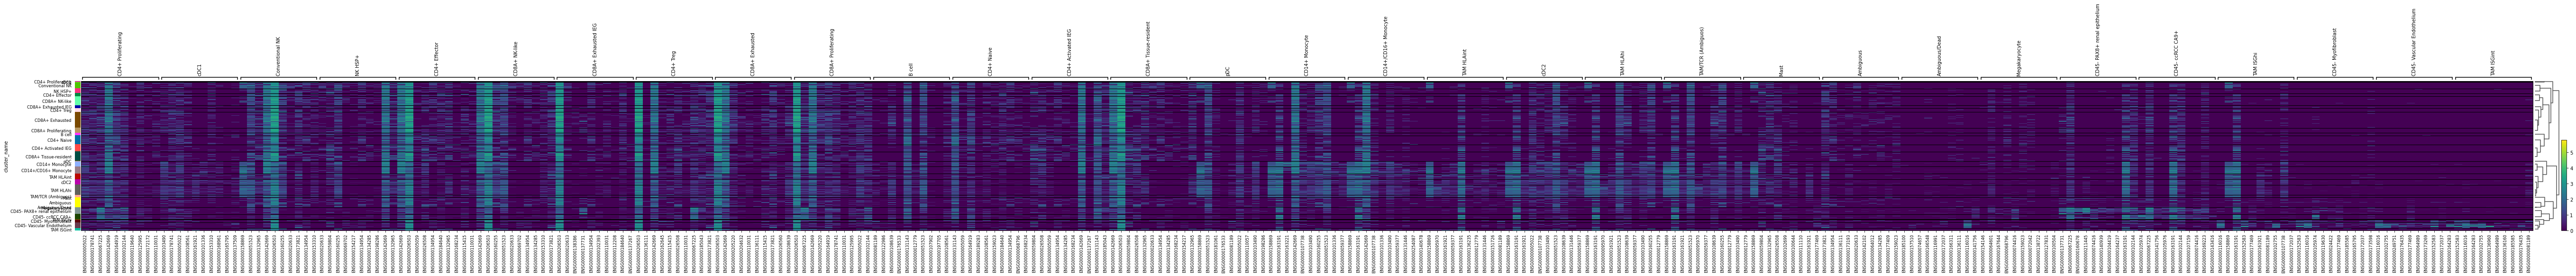

In [11]:
import seaborn as sns
##### Plot heatmap based on the above filtering, to get more specific cell type DE genes.
data_sub_regulatory = data[:,selected_genes]
sc.pp.pca(data_sub_regulatory) # Makes dendrogram construction faster.
sc.tl.dendrogram(data_sub_regulatory, 'cluster_name')
sc.tl.rank_genes_groups(data_sub_regulatory, groupby='cluster_name', use_raw=False, pts=True)
sc.pl.rank_genes_groups_heatmap(data_sub_regulatory,
                                show_gene_labels=True)

# Extract the logFC and rank gene groups from scanpy

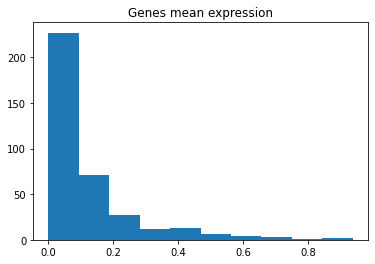

Ambiguous 4
Ambiguous/Dead 0
B cell 9
CD4+ Activated IEG 7
CD4+ Effector 4
CD4+ Naive 11
CD4+ Proliferating 24
CD4+ Treg 7
CD8A+ Exhausted 6
CD8A+ Exhausted IEG 3
CD8A+ NK-like 5
CD8A+ Proliferating 12
CD8A+ Tissue-resident 5
CD14+ Monocyte 40
CD14+/CD16+ Monocyte 42
CD45- Myofibroblast 63
CD45- PAX8+ renal epithelium 163
CD45- Vascular Endothelium 74
CD45- ccRCC CA9+ 132
Conventional NK 8
Mast 6
Megakaryocyte 2
NK HSP+ 11
TAM HLAhi 55
TAM HLAint 35
TAM ISGhi 81
TAM ISGint 46
TAM/TCR (Ambiguos) 29
cDC1 18
cDC2 39
pDC 16


In [12]:
## Each data frame is in the format: columns = cell types, rows = genes.
genes_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['names'])
logfcs_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['logfoldchanges'])
pvals_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['pvals'])
padjs_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['pvals_adj'])
prop_expr_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['pts'])

mean_expression = np.mean(prop_expr_df.values, axis=1)
# Remove all 
plt.hist(mean_expression)
plt.title('Genes mean expression')
plt.show()

# Make a dataframe for each cell type that captures the logFC, padj and proportion of expression for each gene
cell_dfs = {}
for cell_type in genes_df.columns:
    df = pd.DataFrame()
    df[gene_id] = genes_df[cell_type].values
    df['Cell p.adj'] = padjs_df[cell_type].values
    df['Cell logFC'] = logfcs_df[cell_type].values
    df['Cell prop. expressed'] = prop_expr_df[cell_type].values
    # Now let's just filter to only to keep the ones that are significant
    #cell_dfs['TAM ISGhi'][cell_dfs['TAM ISGhi']['Cell prop. expressed'] == 0]
    df = df[df['Cell prop. expressed'] > 0]
    df = df[df['Cell p.adj'] < 0.05]
    df = df[df['Cell logFC'] > 1.0]
    # the cells
    cell_dfs[cell_type] = df
    print(cell_type, len(df))


## Now count DE genes per module, constructing a contigency table OVR style

Do a fischers exact test to see if any of the differentially expressed genes are co-expressing in the same cell type.

In [13]:
from collections import defaultdict 

# Keep track of the counts in each and also the genes that overlapped
columns = ['Regulatory Cluster label', 'Cell type', 'p-value', 'odds-ratio', 
           'genes in cell type and cluster',  
           'genes in cluster but not cell type', 
           'genes in cell type but not cluster', 
           'genes not in cell type or cluster', 
           'gene_ids', 'gene_names']
rows = []
cluster_cell_gene_ids = defaultdict(dict)
for regulatory_cluster, cluster_genes in cluster_gene_map.items():
    # For each cell type, construct contingency table
    for cell_type, df in cell_dfs.items():
        cell_enriched_genes = df[gene_id].values
        cont_table = np.zeros((2,2)) #Rows=ct, not ct; Cols=Module, not Module
        if len(cell_enriched_genes) > 0: # Some DE genes
            in_cell_and_cluster = len(set(cluster_genes) & set(cell_enriched_genes))
            cluster_not_cell = len(cluster_genes) - in_cell_and_cluster
            cell_not_cluster = len(cell_enriched_genes) - in_cell_and_cluster
            if in_cell_and_cluster > 3:  # Require there to be at least 3 genes overlapping
                not_cell_not_cluster = len(selected_genes) - (in_cell_and_cluster + cluster_not_cell + cell_not_cluster)
                # Populating cont table
                cont_table[0,0] = in_cell_and_cluster
                cont_table[1,0] = cluster_not_cell
                cont_table[0,1] = cell_not_cluster
                cont_table[1,1] = not_cell_not_cluster
                # Doing FET, Enrichment IN cell type, only.
                odds_ratio, pval = fisher_exact(cont_table, alternative="greater")
                genes_ids = list(set(cluster_genes) & set(cell_enriched_genes))
                gene_names = [gene_name_map[gene] for gene in genes_ids]
                cluster_cell_gene_ids[regulatory_cluster][cell_type] = genes_ids
                rows.append([regulatory_cluster, cell_type, pval, odds_ratio, in_cell_and_cluster, 
                             cluster_not_cell, cell_not_cluster, not_cell_not_cluster, ' '.join(genes_ids), ' '.join(gene_names)])

odds_ratio_df = pd.DataFrame(data=rows, columns=columns)
reg, padj, a, b = multipletests(odds_ratio_df['p-value'].values,
                                alpha=0.05, method='fdr_bh', returnsorted=False)
odds_ratio_df['p.adj'] = padj

## Plot the resulting genes and the groups

In [14]:
sig_odds_ratio_df = odds_ratio_df[odds_ratio_df['p.adj'] < 0.05]
sig_odds_ratio_df.to_csv(f'{output_dir}{run_label}_sig_odds_ratio_df.csv', index=False)
odds_ratio_df.to_csv(f'{output_dir}{run_label}_odds_ratio_df.csv', index=False)

In [15]:
# Make a square dataframe based on the odds ratio
rows = []
cell_types = sig_odds_ratio_df['Cell type'].unique()
cluster_labels = sig_odds_ratio_df['Regulatory Cluster label'].unique()

# Let's get an ordered dict of the values so that we can use them later
plotting_gene_map = defaultdict(list) # Get the sig ones since we don't want to plot all!
for cell_type in cell_types:
    values = [cell_type]
    for cluster in cluster_labels:
        cell = sig_odds_ratio_df[sig_odds_ratio_df['Cell type'] == cell_type]
        if len(cell) > 0:
            cell_cluster = cell[cell['Regulatory Cluster label'] == cluster]
            if len(cell_cluster) > 0:
                values.append(cell_cluster['odds-ratio'].values[0])
                # get the genes in this group
                genes = cell_cluster['gene_ids'].values[0].split(' ')
                
                # Add the genes from this group
                gene_to_value = {g:gene_padj_map[g] for g in genes}
                # Sort gene_to_value
                gene_to_value_sorted = dict(sorted(gene_to_value.items(), key=lambda item: item[1]))
                # Get the genes for each of the cell types
                plotting_gene_map[cluster] += list(gene_to_value_sorted.keys())[:5]

            else:
                values.append(0)
        else:
            values.append(0)
    rows.append(values)

square_df = pd.DataFrame(data=rows, columns=['cell type'] + list(cluster_labels))
square_df.set_index('cell type', inplace=True)
# Make sure there weren't any duplicates
for c in plotting_gene_map:
    plotting_gene_map[c] = list(set(plotting_gene_map[c]))

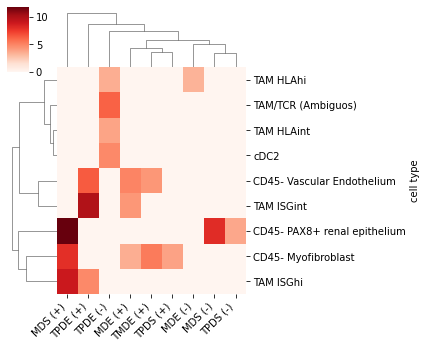

In [16]:
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
ax = sns.clustermap(square_df, cmap="Reds", figsize=(6,5))
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
if save_fig:
    plt.savefig(f'{output_dir}{run_label}_heatmap_output_singlecell.svg')

## Set up data for plotting specific genes and clusters

In [17]:
df = pd.DataFrame(data=data.X.todense().T)
df.index = data.var.index # Set the gene names to be the IDs
df.columns = data.obs.index # Set the gene names to be the IDs

In [18]:
# Run the heatmap and umap's for the different groups
reg_df = df.loc[selected_genes]

In [19]:
# Now let's all add in the ones that are significant as per the regulatory labels
gene_ids = sig_odds_ratio_df['gene_ids'].values
cell_types = sig_odds_ratio_df['Cell type'].values
gene_to_label = defaultdict(list)
for i, reg_label in enumerate(sig_odds_ratio_df['Regulatory Cluster label'].values):
    genes = gene_ids[i].split(' ')
    for gene in genes:
        gene_to_label[gene].append(f'{reg_label}_{cell_types[i]}')


In [20]:
# Things we want to plot, the mean expression of the genes in a specific cell type 
# So let's make a DF that has this info which means getting the cells that belong to each cell type
cell_expr_df = pd.DataFrame()
cell_expr_df['GeneId'] = reg_df.index.values
cell_expr_df['GeneName'] = [gene_name_map.get(g) for g in reg_df.index.values]
cell_expr_df['RegulatoryCluster'] = [gene_cluster_map.get(g) for g in reg_df.index.values]
labels = []
for g in reg_df.index.values:
    if gene_to_label.get(g) is not None:
        labels.append('|'.join(gene_to_label.get(g)))
    else:
        labels.append('')
cell_expr_df['SigCellCluster'] = labels
for cell_type in data_sub_regulatory.obs.cluster_name.unique():
    # Get the cells belonging to that cluster
    cell_ids = data_sub_regulatory.obs[data_sub_regulatory.obs.cluster_name == cell_type].index.values
    mean_expr = np.nanmean(reg_df.loc[:, cell_ids], axis=1)
    # add that for that cell 
    cell_expr_df[cell_type] = mean_expr
    
# Create an ID based on gene and the cluster
sig_cell_expr_df = cell_expr_df[cell_expr_df['SigCellCluster'] != '']
sig_cell_expr_df['ID'] = [f'{sig_cell_expr_df.GeneName.values[i]} {s}' for i, s in enumerate(sig_cell_expr_df.SigCellCluster.values)]
sig_cell_expr_df.set_index('GeneId', inplace=True)

# Add these info to the cellxgene df
reg_df['GeneName']= [gene_name_map.get(g) for g in reg_df.index.values]
reg_df['RegulatoryCluster'] = [gene_cluster_map.get(g) for g in reg_df.index.values]
reg_df['SigCellCluster'] = labels

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/2352140349.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_cell_expr_df['ID'] = [f'{sig_cell_expr_df.GeneName.values[i]} {s}' for i, s in enumerate(sig_cell_expr_df.SigCellCluster.values)]


### Z-transform for visualisation

In [21]:
from sciviso import Heatmap
# Normalise each row (i.e. each gene) by the overall means from each cell type
cols= [c for c in sig_cell_expr_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster', 'ID', 'GeneId']]
data = sig_cell_expr_df[cols].values.copy()
# Min max scale this data
data_values = []  # Basically just going to normalise each row
for i, row in enumerate(data):
    if row.max() == 0:
        data_values.append(row)
    else:
        non_zero_min = np.min(row)
        non_zero_max = np.max(row)
        non_zero_mean = np.mean(row)
        non_zero_std = np.std(row)
        new_values = []
        for j, val in enumerate(row):
            if val > 0:
                new_values.append((val - non_zero_mean) /non_zero_std)
            else:
                new_values.append(0)
        data_values.append(new_values)

# Refill in the normalised protein data
new_df = pd.DataFrame(data_values, index=sig_cell_expr_df.index, columns=cols)
new_df['GeneName']= sig_cell_expr_df.GeneName.values
new_df['RegulatoryCluster'] =  sig_cell_expr_df.RegulatoryCluster.values
new_df['SigCellCluster'] =  sig_cell_expr_df.SigCellCluster.values
new_df['ID'] =  sig_cell_expr_df.ID.values

In [22]:
# Make a square dataframe based on the odds ratio
cluster_labels = new_df['RegulatoryCluster'].unique()

# Let's get an ordered dict of the values so that we can use them later
plotting_gene_map_cell = defaultdict(list) # Get the sig ones since we don't want to plot all!
for cluster in cluster_labels:
    r_df = new_df[new_df['RegulatoryCluster'] == cluster]
    if len(r_df) > 0:
        gene_to_value = {}
        for i, gene in enumerate(r_df.index.values):
            for column in r_df:
                gene_to_value[gene] = r_df[column].values[i]
        # Sort gene_to_value
        gene_to_value_sorted = dict(sorted(gene_to_value.items(), key=lambda item: item[1]))
        # Get the genes for each of the cell types
        plotting_gene_map_cell[cluster] += list(gene_to_value_sorted.keys())[:5]
    else:
        values.append(0)
# Make sure there weren't any duplicates
for c in plotting_gene_map:
    plotting_gene_map_cell[c] = list(set(plotting_gene_map_cell[c]))

In [23]:
# Normalise each row by the z transform of each cell 
cols= [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]
data = reg_df[cols].values.copy()
# Min max scale this data
data_values = []  # Basically just going to normalise each row
for i, row in enumerate(data):
    if row.max() == 0:
        data_values.append(row)
    else:
        non_zero_min = np.min(row)
        non_zero_max = np.max(row)
        non_zero_mean = np.mean(row)
        non_zero_std = np.std(row)
        new_values = []
        for j, val in enumerate(row):
            if val > 0:
                new_values.append((val - non_zero_mean) /non_zero_std)
            else:
                new_values.append(0)
        data_values.append(new_values)

# Refill in the normalised protein data
cols = [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]
new_reg_df = pd.DataFrame(data_values, index=reg_df.index, columns=cols)
new_reg_df['GeneName']= reg_df.GeneName.values
new_reg_df['RegulatoryCluster'] =  reg_df.RegulatoryCluster.values
new_reg_df['SigCellCluster'] =  reg_df.SigCellCluster.values

In [24]:
# Make the colours consistent throughout 
cell_colours = {
    'CD8A+ Exhausted IEG': '#b3b3ff',
    'CD8A+ Exhausted': '#003d66',
    'CD8A+ Proliferating': '#6666ff',
    'CD4+ Proliferating': '#3d0099',
    'CD4+ Treg': '#c299ff',
    'CD4+ Naive': '#8800cc',
    'CD8A+ Tissue-resident': '#005c99',
    'CD4+ Activated IEG': '#6600ff',

    'Ambiguous': '#000000',
    'CD4+ Effector': '#944dff',
    'CD8A+ NK-like': '#0000ff',
    'Conventional NK': '#ff8533',
    'NK HSP+': '#b34700',

    'TAM HLAhi': '#cca300',
    'TAM/TCR (Ambiguos)': '#665200',
    'TAM HLAint': '#ffd633',

    'cDC2': '#86b300',

    'CD14+ Monocyte': '#660066',
    'CD14+/CD16+ Monocyte': '#b300b3',

    'Mast': '#006600',
    'B cell': '#00b300',
    'Megakaryocyte': '#1aff1a',

    'CD45- Myofibroblast': '#812c81',

    'CD45- ccRCC CA9+': '#800000',
    'CD45- PAX8+ renal epithelium': '#642020',
    'CD45- Vascular Endothelium': '#ff4d4d',


    'TAM ISGhi': '#ff8800',
    'TAM ISGint': '#ffff99',

    'cDC1': '#ace600',
    'pDC': '#4d6600',

    'Ambiguous/Dead': '#000000'
}

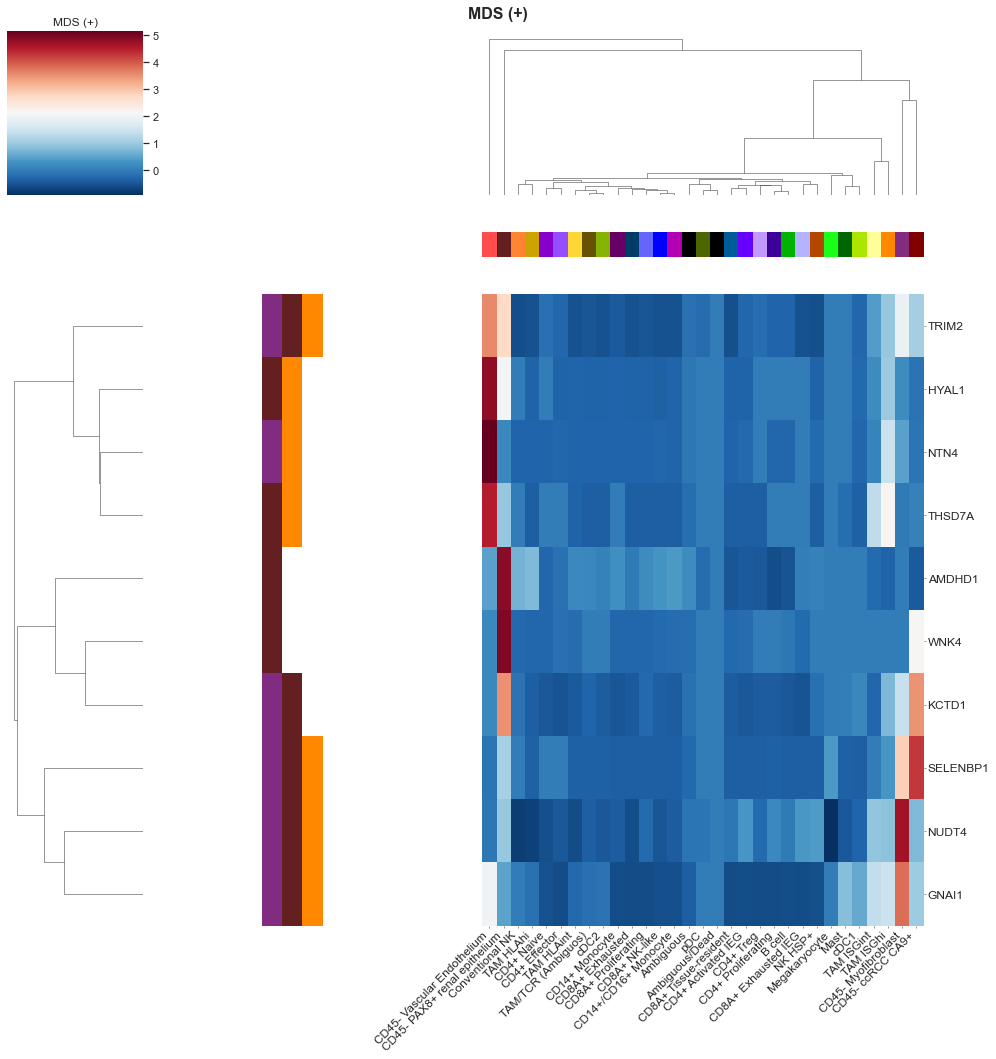

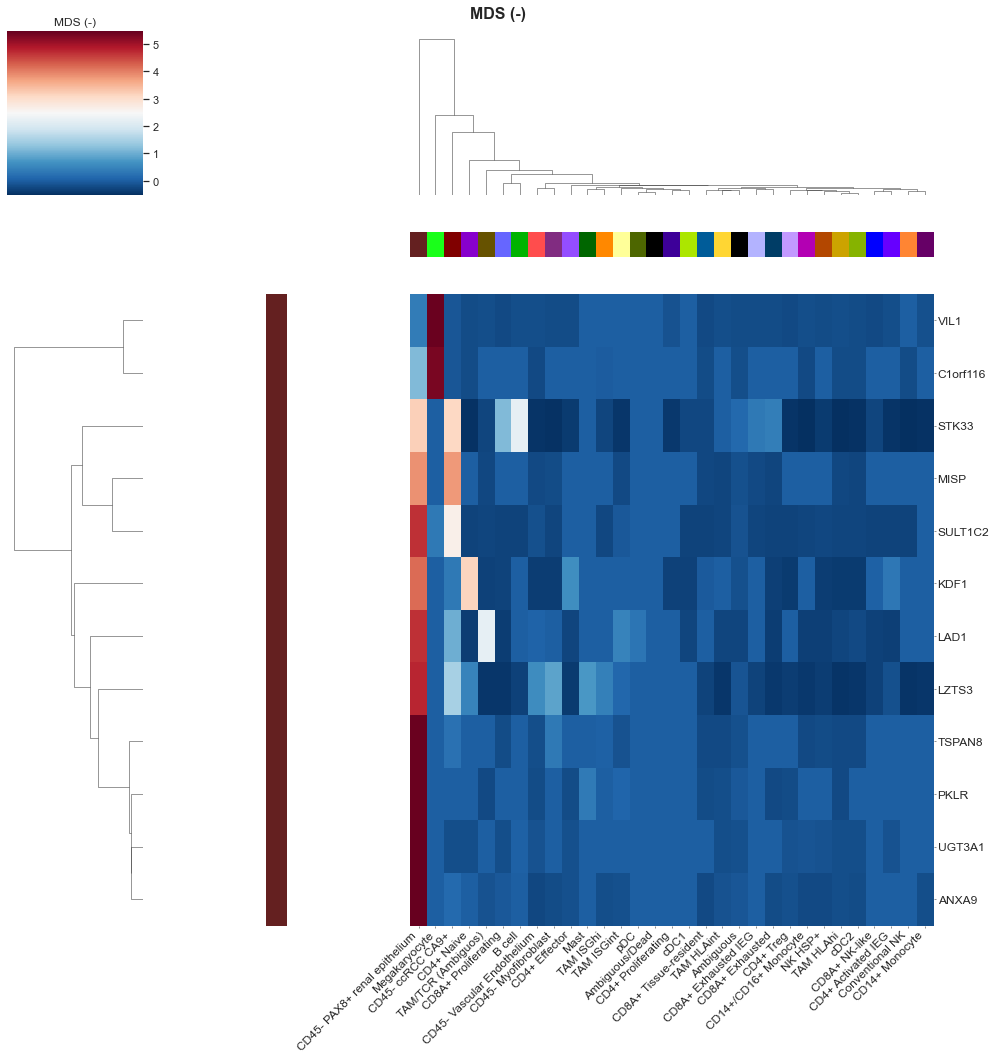

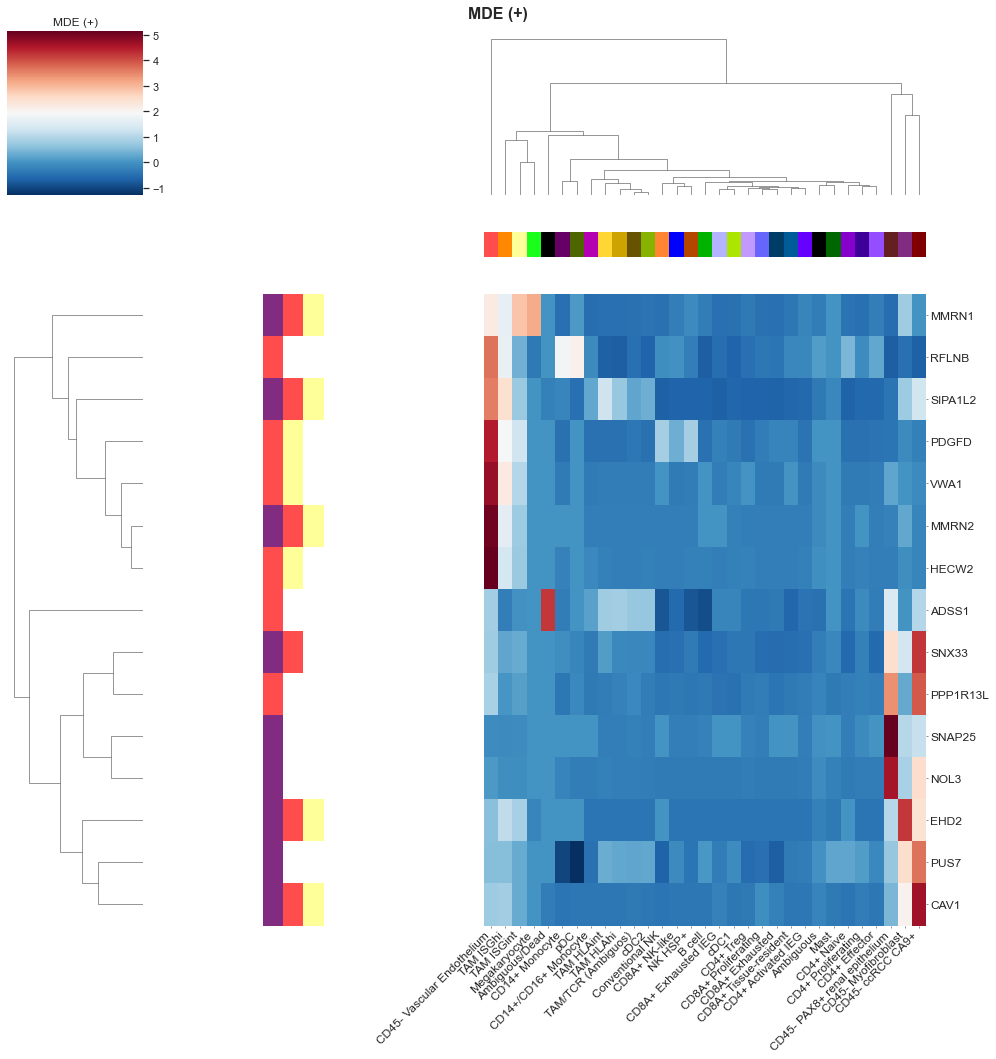

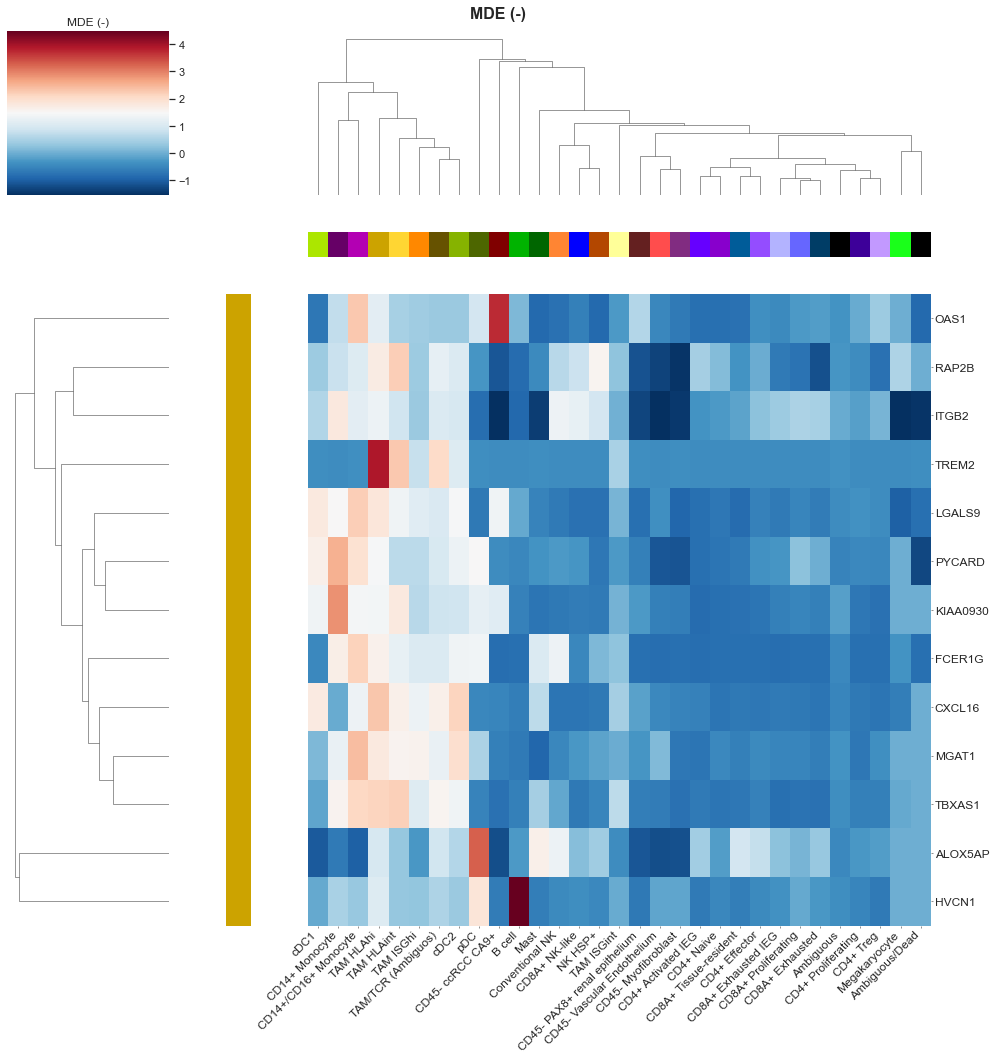

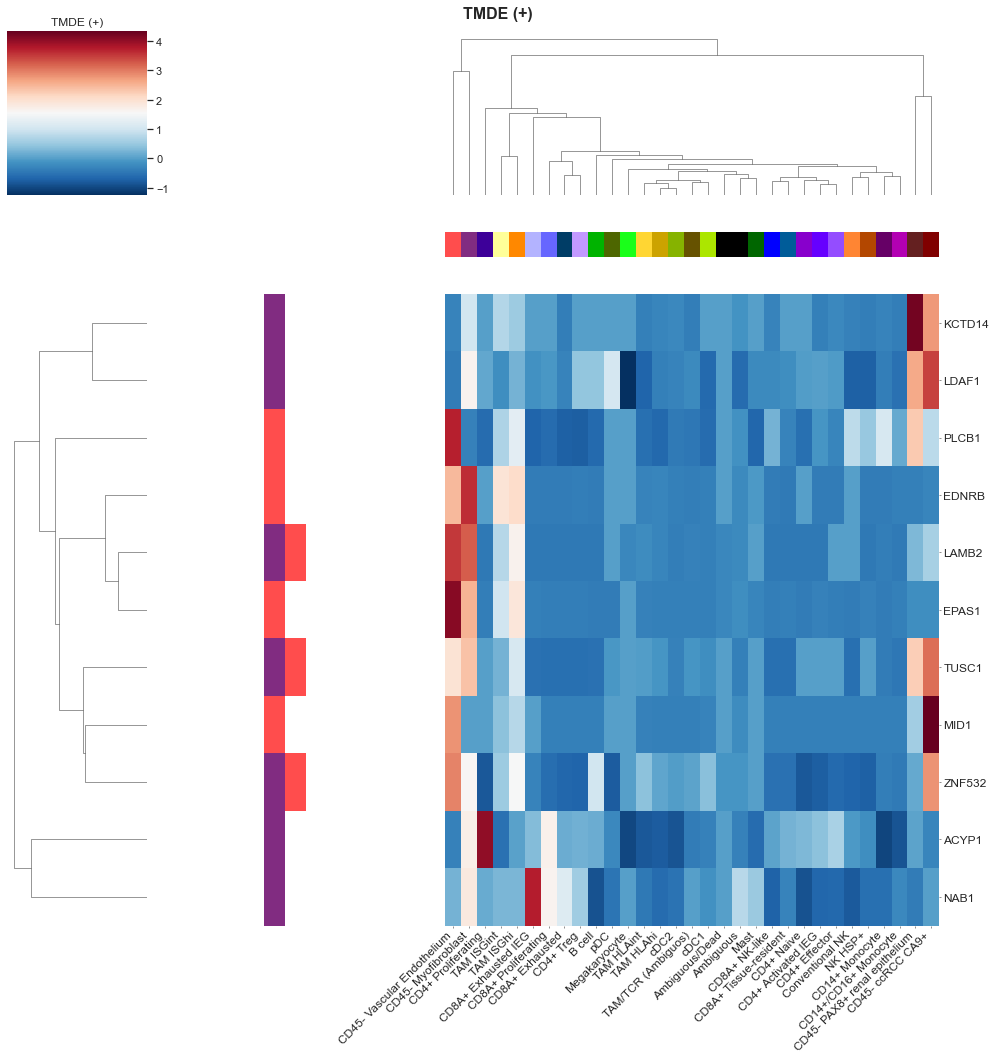

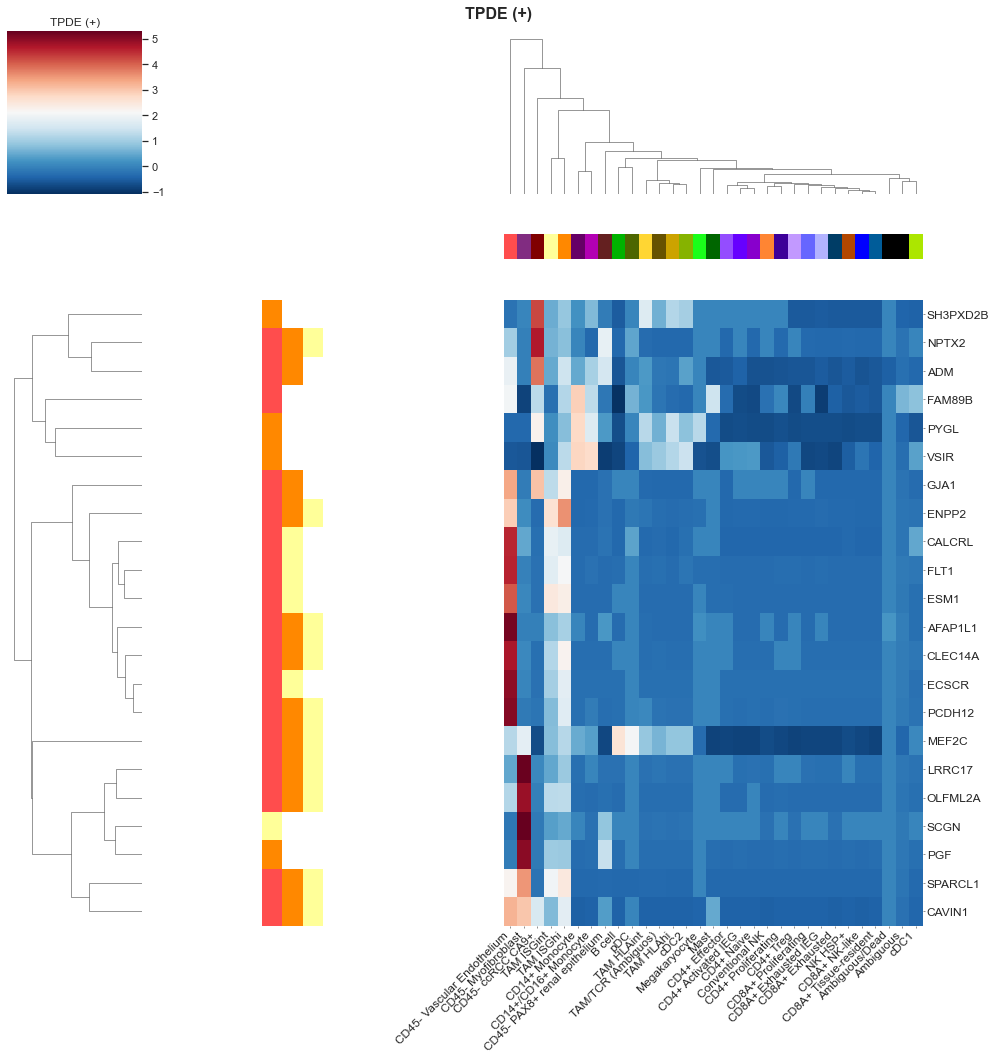

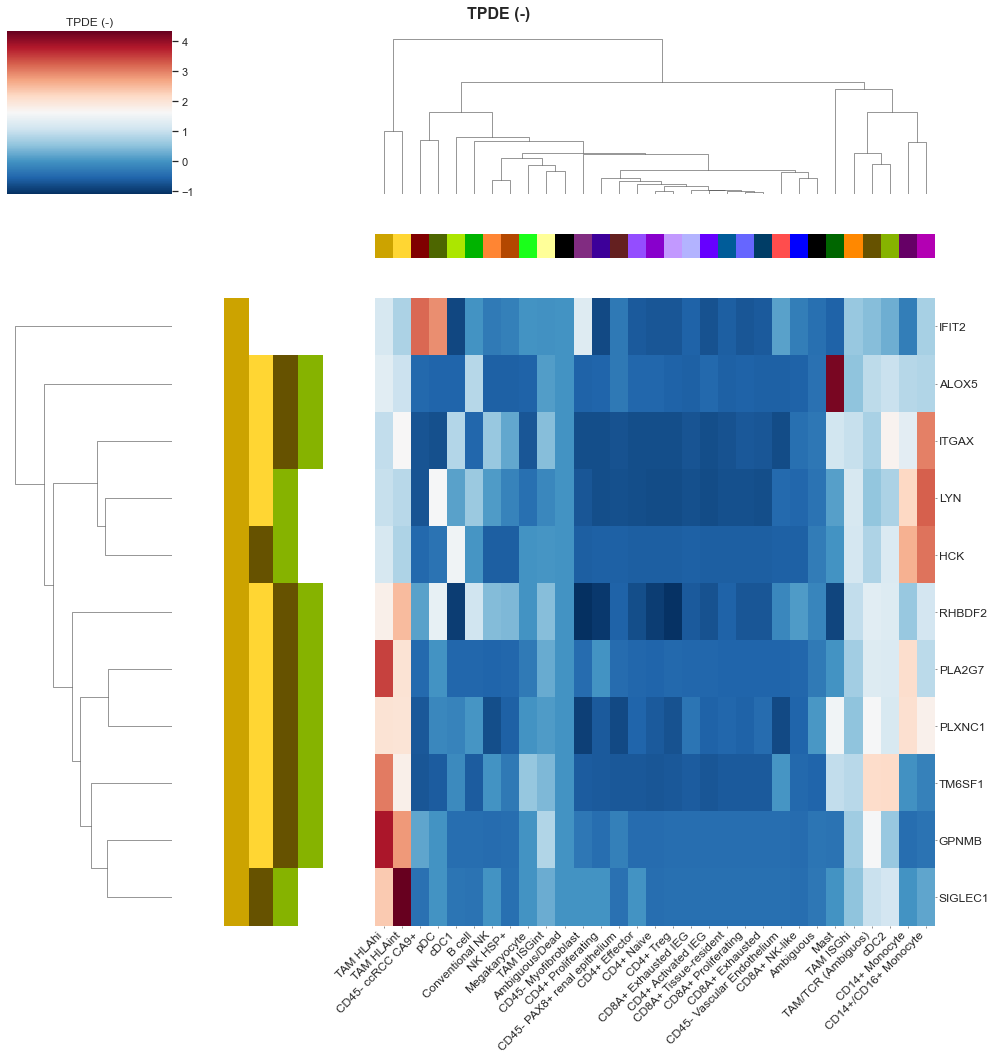

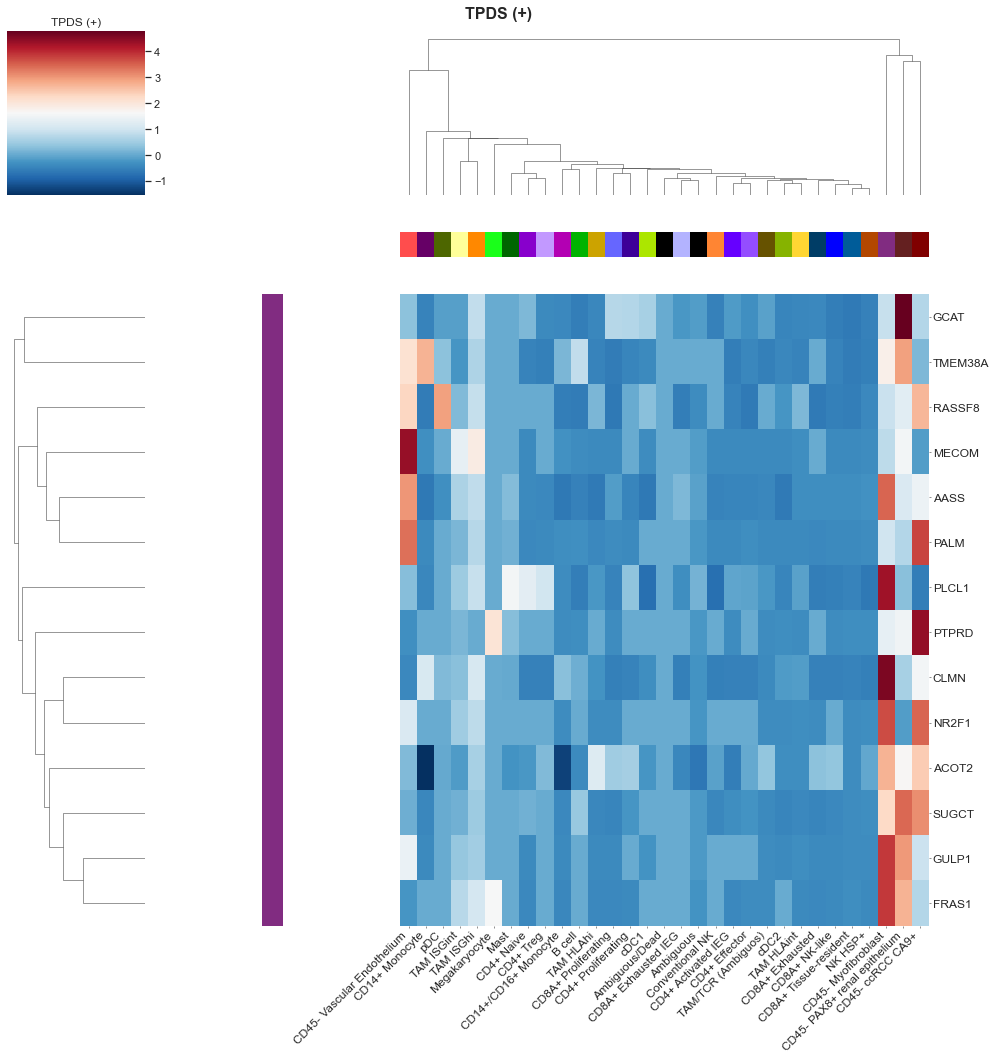

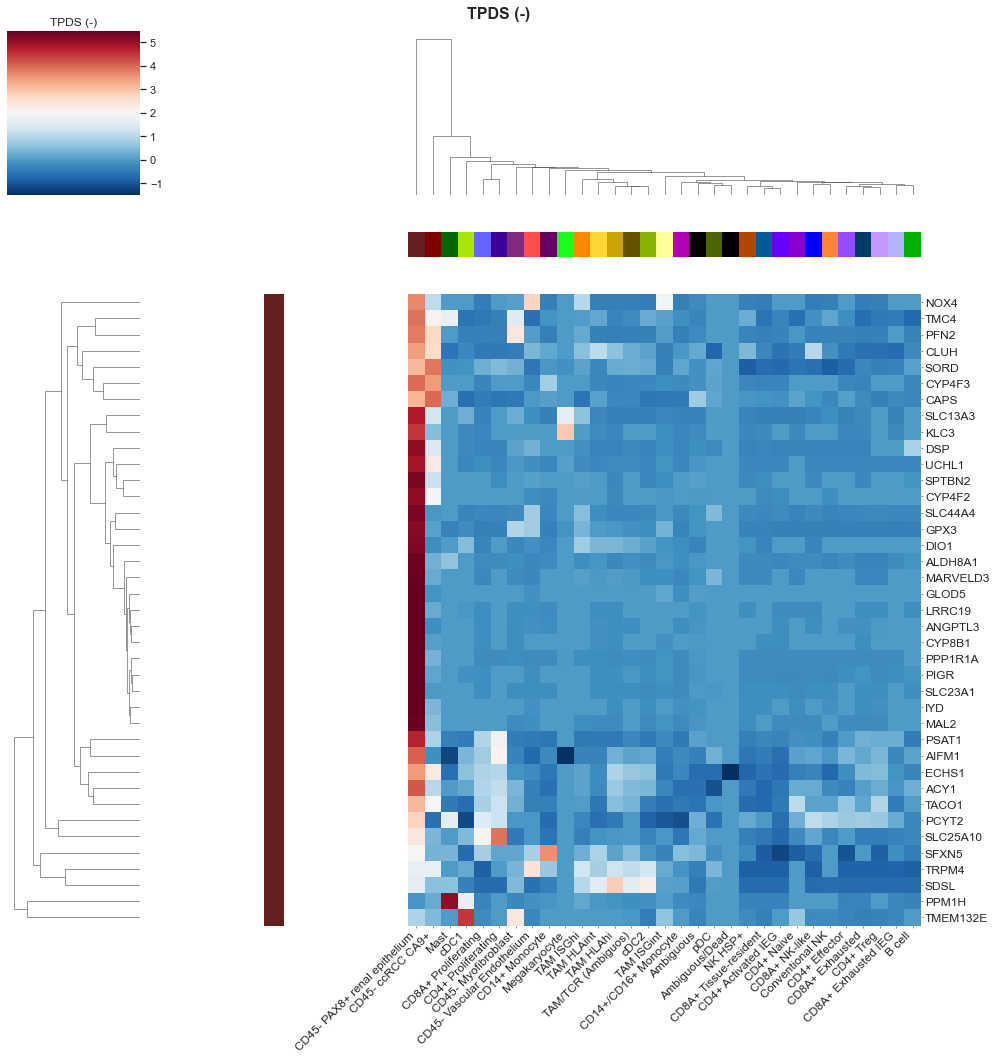

In [25]:
# Now use these two to make heatmap for each regulatory cluster
import matplotlib.pyplot as plt

vis_opts = {'figsize': (14, 15), 'axis_font_size': 12, 'label_font_size': 12, 'title_font_size': 16}
cols = [c for c in sig_cell_expr_df.columns if c not in ['GeneId', 'GeneName', 'RegulatoryCluster', 
                                                         'SigCellCluster', 'ID']]

for reg_label in new_df.RegulatoryCluster.unique():
    # Do a heatmap
    heat_df = new_df[new_df.RegulatoryCluster == reg_label]
    row_colours = [[] for c in heat_df.SigCellCluster.unique()]
    for c in heat_df.SigCellCluster.values:
        cell_types = [x.split('_')[1] for x in c.split('|')]
        for i in range(0, len(row_colours)):
            if i >= len(cell_types):
                row_colours[i].append('white')
            else:
                row_colours[i].append(cell_colours[cell_types[i]])
    # Need to work out for these guys how many unique cell types there are
    col_colours = [cell_colours[c] for c in cols]
    if len(heat_df) > 0:
        vis = Heatmap(heat_df, cols, 'GeneName', config=vis_opts, title=reg_label,
                      row_colours=row_colours, col_colours=col_colours, annot=False)
        vis.plot()
        plt.show()

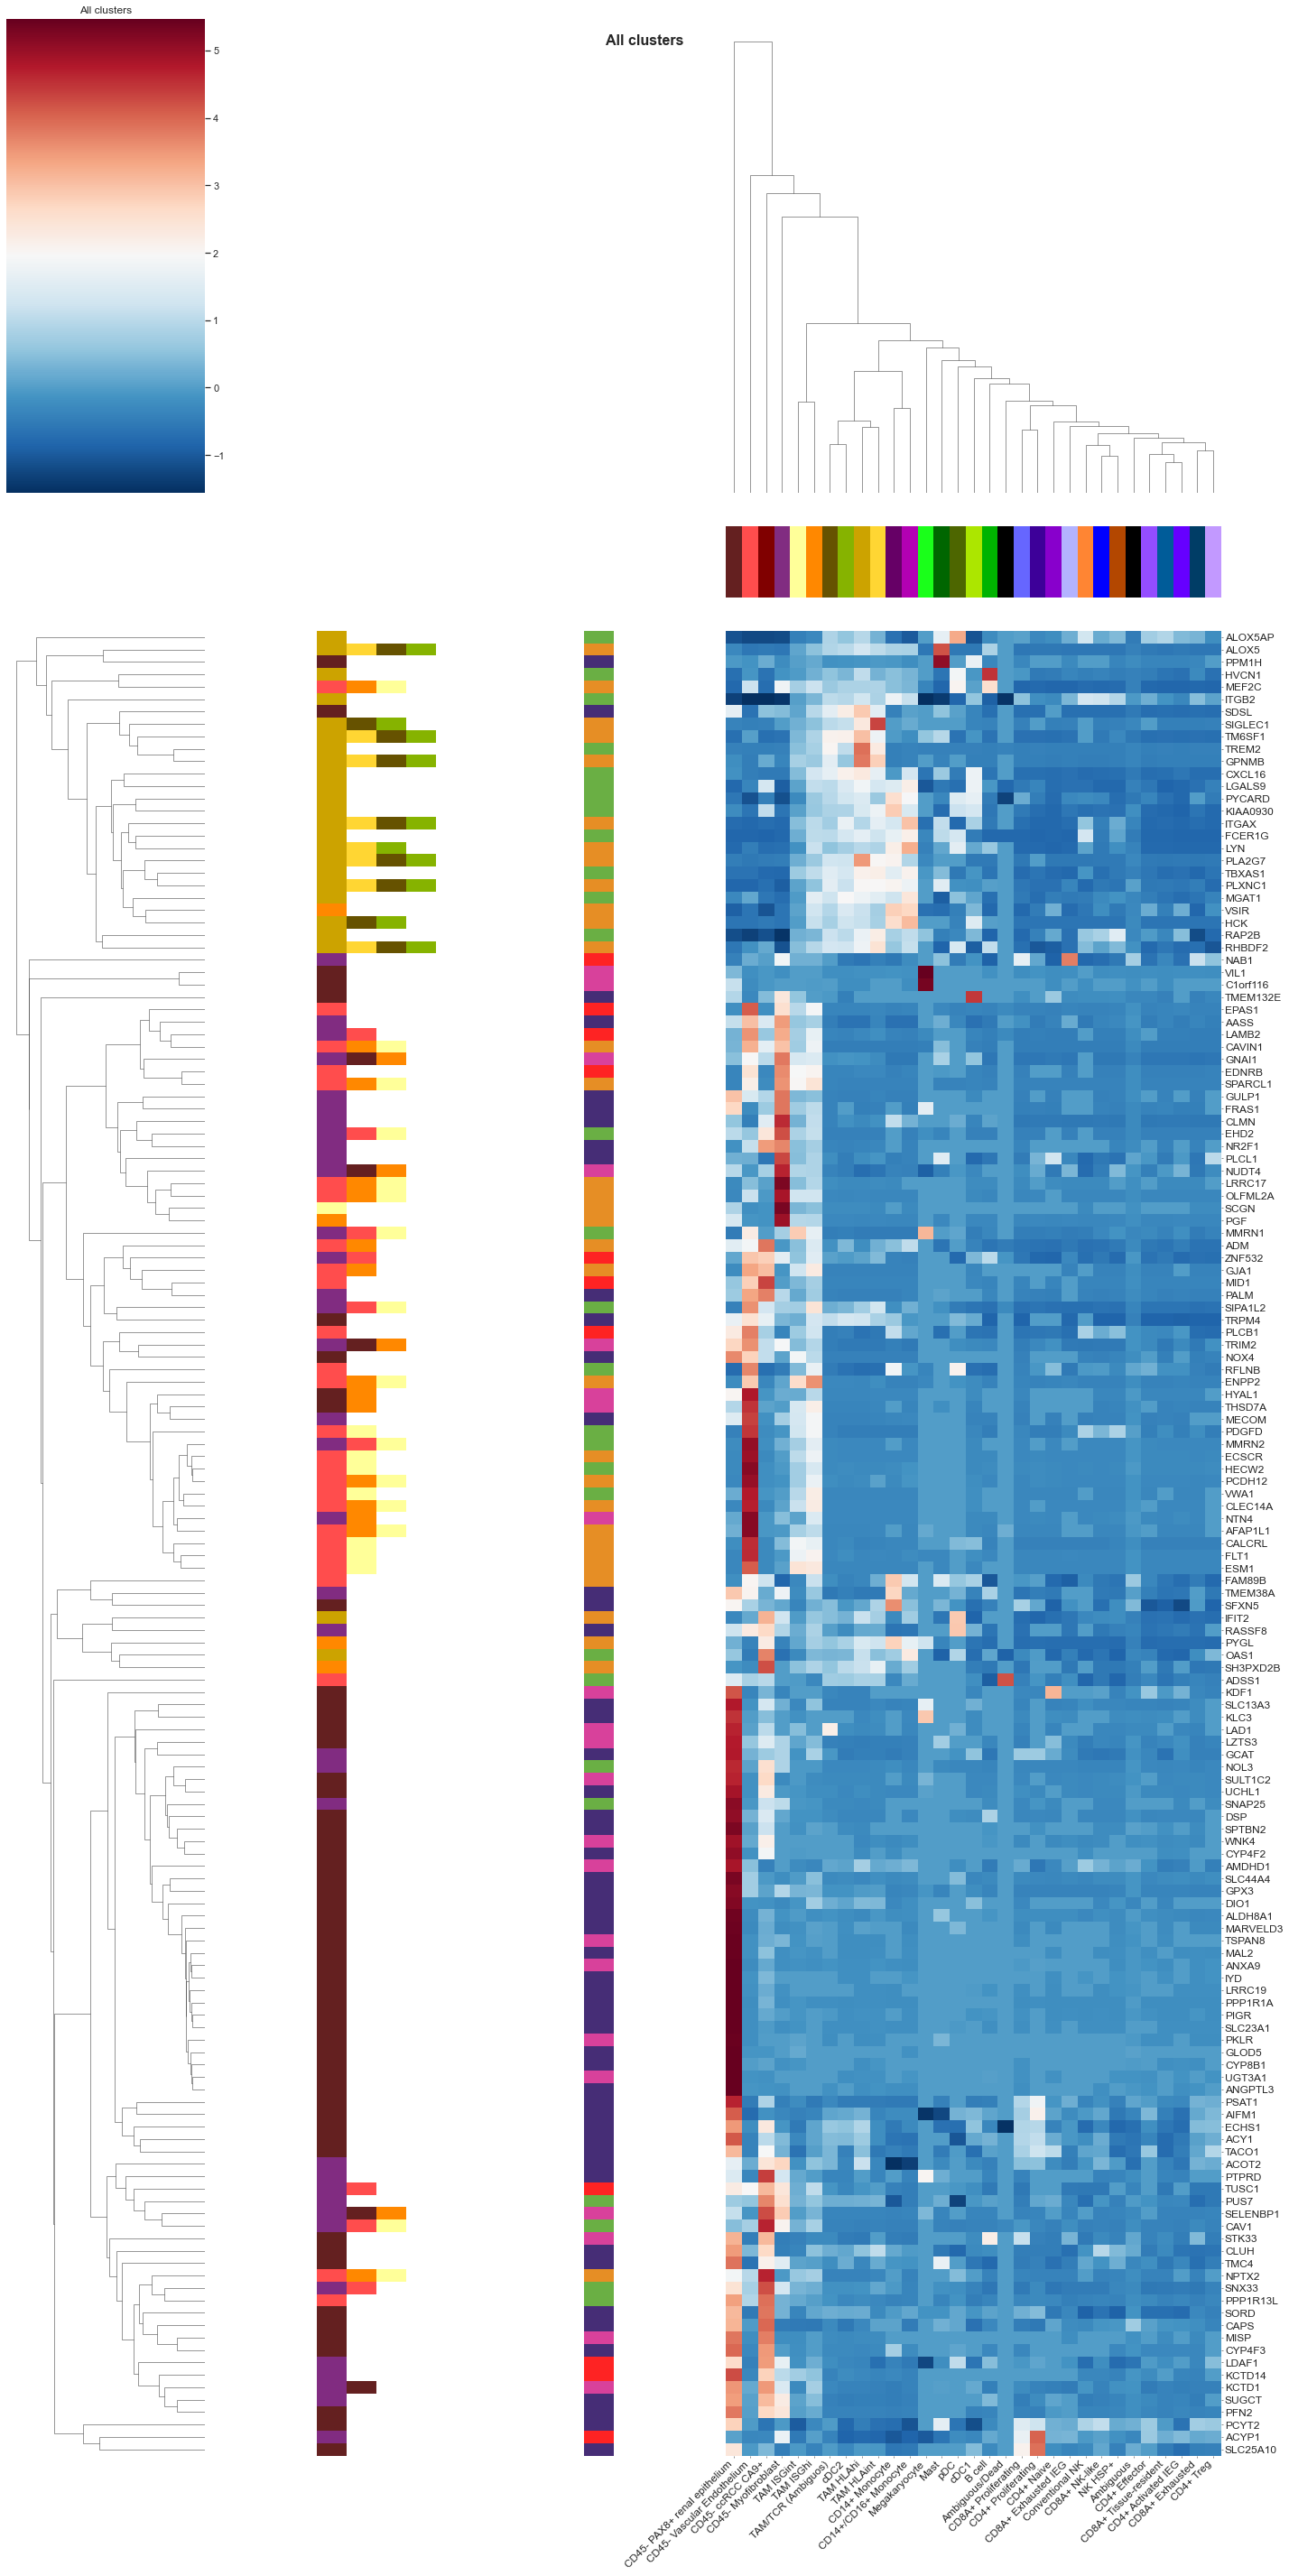

In [26]:

# Add in our colours for each regulatory cluster
colour_map = { 'MDS': '#d8419b', 'MDS_TMDE': '#e585c0', 'MDS_ncRNA': '#d880b4',
               'MDE': '#6aaf44', 'MDE_TMDS': '#0e8e6d', 'MDE_ncRNA': '#9edb77',
               'TMDE': '#fe2323', 'TMDS': '#2952ff',
               'TPDE': '#e68e25', 'TPDE_TMDS': '#844c0f',
                'TPDS': '#462d76', 'TPDS_TMDE': '#9b29b7'}

# Do a heatmap
vis_opts = {'figsize': (20, 40), 'axis_font_size': 12, 'label_font_size': 12, 'title_font_size': 16}
cols = [c for c in sig_cell_expr_df.columns if c not in ['GeneId', 'GeneName', 'RegulatoryCluster', 'SigCellCluster', 'ID']]

heat_df = new_df.copy()

reg_label_colours = []

for c in heat_df.RegulatoryCluster.values:
    colour = colour_map[c.split(' ')[0]]
    reg_label_colours.append(colour)

cell_types = []
for c in heat_df.SigCellCluster.values:
    cell_types += [x.split('_')[1] for x in c.split('|')]
    
cell_types = list(set(cell_types))
row_colours = [[] for c in cell_types]
for c in heat_df.SigCellCluster.values:
    cell_types = [x.split('_')[1] for x in c.split('|')]
    for i in range(0, len(row_colours)):
        if i >= len(cell_types):
            row_colours[i].append('white')
        else:
            row_colours[i].append(cell_colours[cell_types[i]])
row_colours.append(reg_label_colours)
# Need to work out for these guys how many unique cell types there are
col_colours = [cell_colours[c] for c in cols]

if len(heat_df) > 0:
    vis = Heatmap(heat_df, cols, 'GeneName', config=vis_opts, title='All clusters',
                  col_colours=col_colours, row_colours=row_colours)
    vis.plot()
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_all_gene_cluster.svg')
    plt.show()

## UMAP visualisations

In [27]:
# Create a UMAP DF for visualisations
umap_df = pd.DataFrame()
umap_df.index = data_sub_regulatory.obs.index.values
umap_df['UMAP 1'] =  data_sub_regulatory.obs.UMAP1
umap_df['UMAP 2'] =  data_sub_regulatory.obs.UMAP2
umap_df['Cell Type'] =  data_sub_regulatory.obs.cluster_name

# Add a colours into the plotting
colours = [cell_colours.get(c) for c in data_sub_regulatory.obs.cluster_name.values]
data_sub_regulatory.uns['cluster_name_colors'] = colours

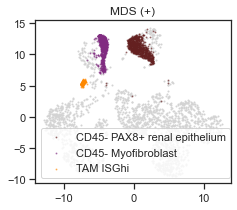

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


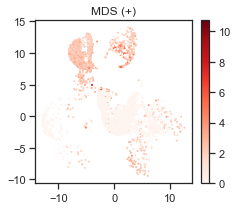

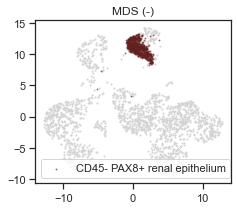

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


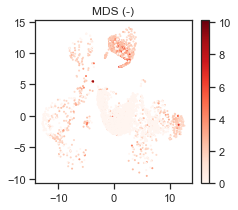

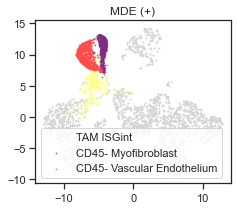

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


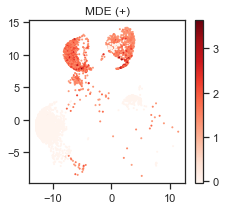

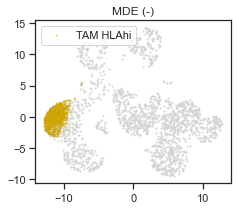

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


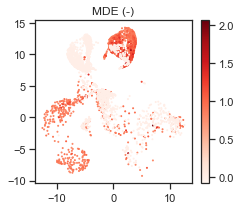

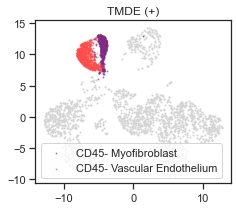

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


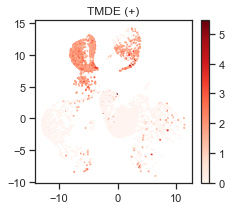

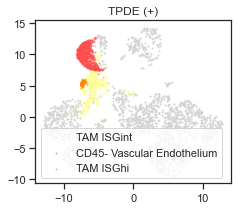

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


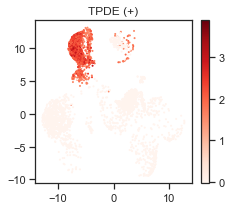

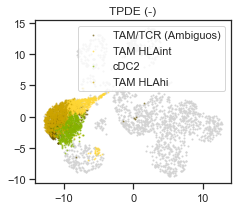

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


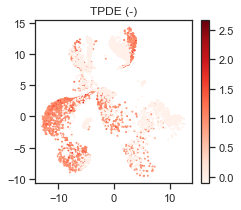

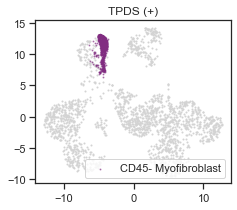

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


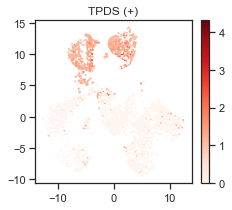

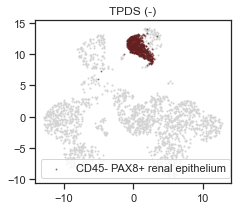

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_8455/1012948283.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


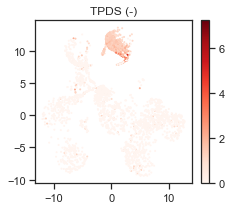

In [28]:
##### Plotting the significant cases
labels = []
cols = [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]
plt.rcParams["figure.figsize"] = (3.5,3)
for i, reg_label in enumerate(new_df.RegulatoryCluster.unique()):
    r_df =  new_reg_df[new_reg_df.RegulatoryCluster == reg_label]
    genes = r_df.RegulatoryCluster.index.values
    mean_expr = np.nanmean(r_df.loc[genes, cols], axis=0) # Mean expression along the cell types
    
    data_sub_regulatory.obs[f'{reg_label}'] = mean_expr
    cell_types = []
    for c in r_df.SigCellCluster.unique():
        c = c.split('|')
        for sx in c:
            if len(sx.split('_')) > 1:
                cell_types.append(sx.split('_')[1])
    cell_types = list(set(cell_types))
    ### Plotting cell type location on umap, scores on umap, and violin plot of scores across cts
    cell_umap = umap_df[~umap_df['Cell Type'].isin(c)].sample(n=2000)
    plt.scatter(cell_umap['UMAP 1'].values, cell_umap['UMAP 2'].values, c='lightgrey', alpha=1.0, s=1)
    for c in cell_types:
        cell_umap = umap_df[umap_df['Cell Type'] == c]
        if len(cell_umap) > 800:
            cell_umap = cell_umap.sample(n=800)
        plt.scatter(cell_umap['UMAP 1'].values, cell_umap['UMAP 2'].values, c=cell_colours.get(c), 
                        label=c, alpha=0.5, s=1)
    plt.title(reg_label)
    plt.legend()
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_{reg_label}_clusters.svg')
    plt.show()

    top_expressed_cells = list(np.argpartition(mean_expr, -2000)[-2000:])
    top_expressed_cells += list(np.argpartition(mean_expr, 2000)[:2000])

    cell_umap = umap_df.iloc[top_expressed_cells,:]
    cell_umap['Mean expr'] = mean_expr[top_expressed_cells]
    x = plt.scatter(cell_umap['UMAP 1'].values, cell_umap['UMAP 2'].values, c=cell_umap['Mean expr'].values, 
                        alpha=1.0, s=1, cmap='Reds')#, vmin=0, vmax=4)
    plt.colorbar()
    plt.title(reg_label)
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_{reg_label}_scatter-mean_nocolourbar.svg')
    plt.show()
    

## Do the same with the default scanpy functions

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


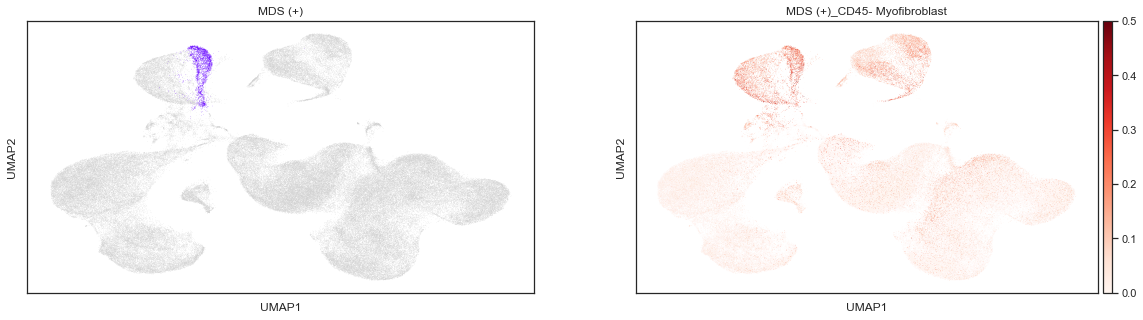

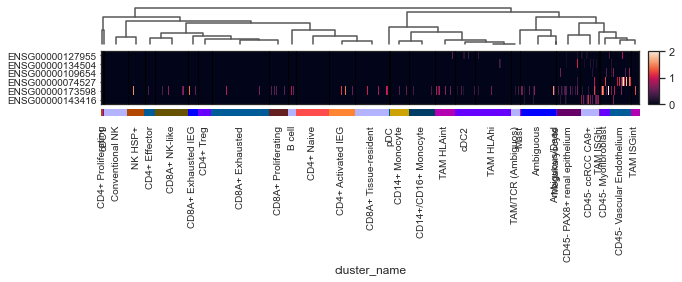

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


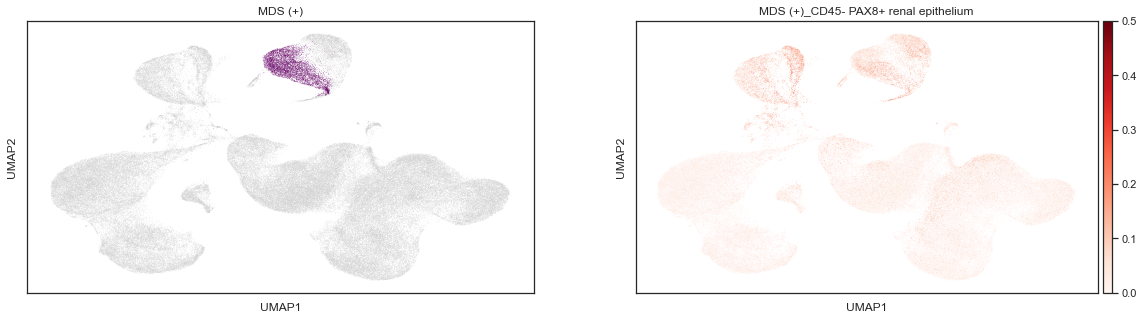

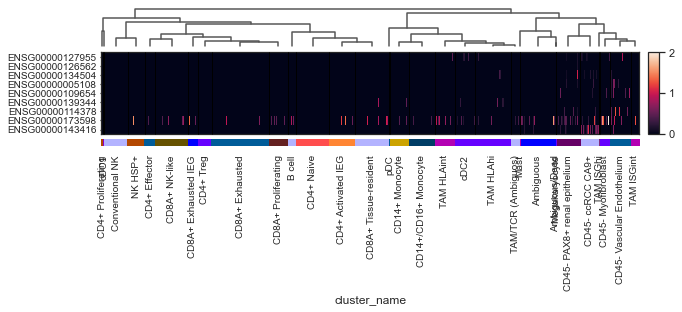

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


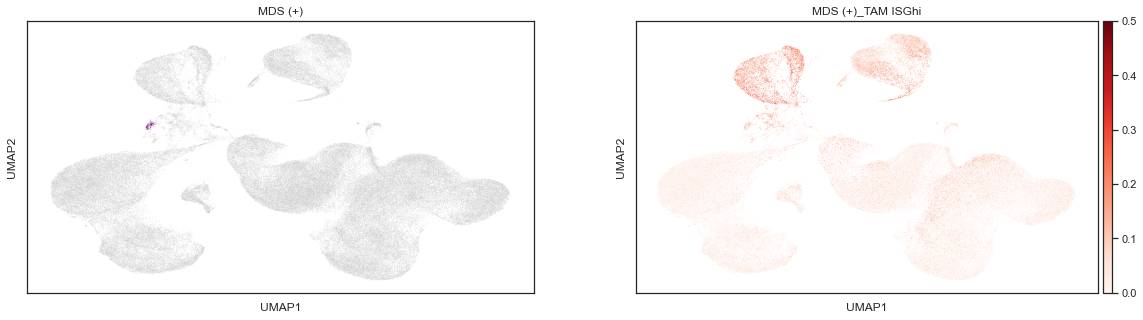

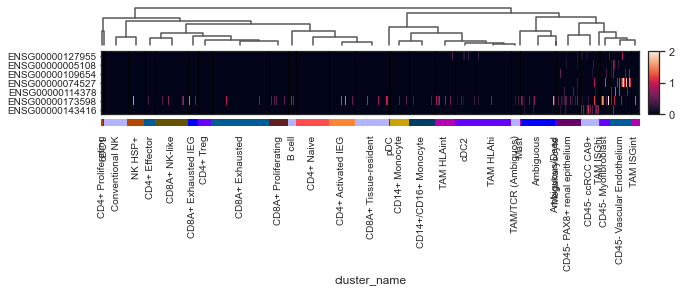

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


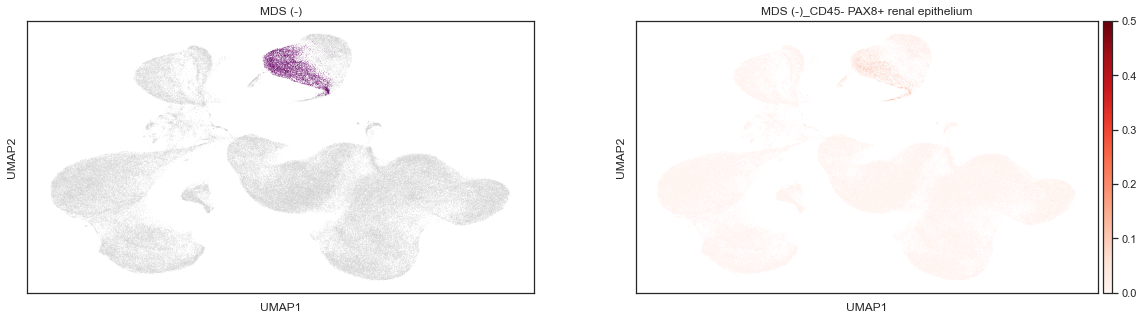

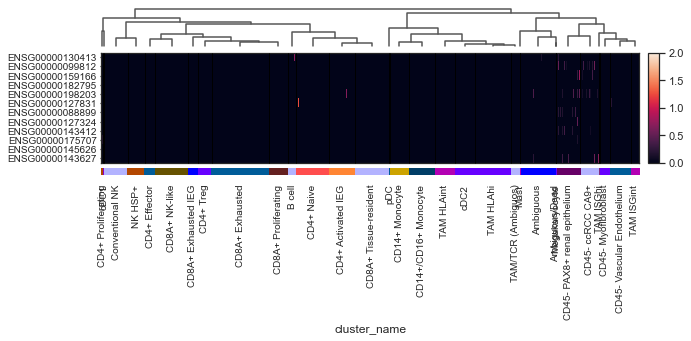

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


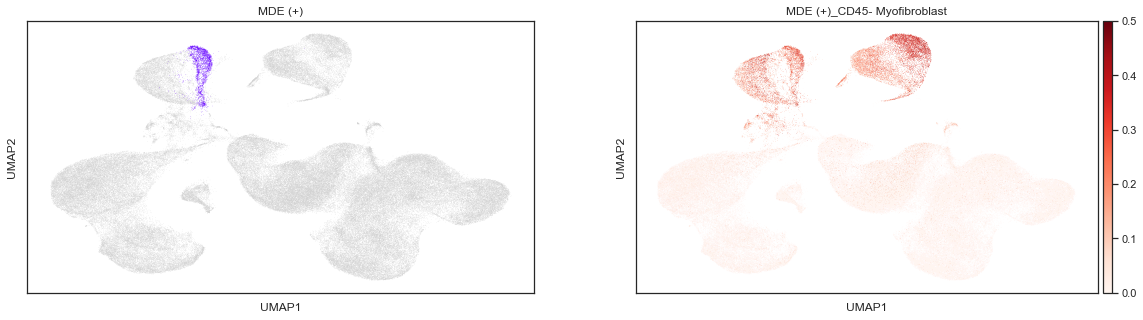

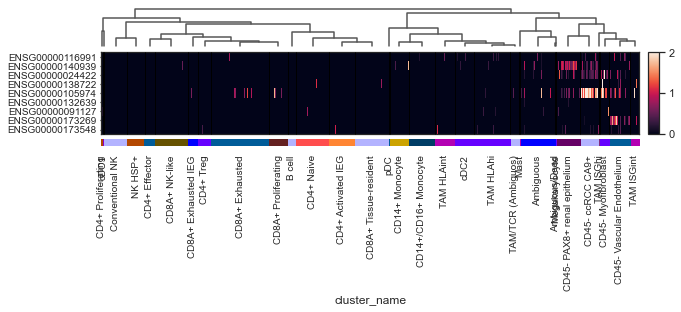

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


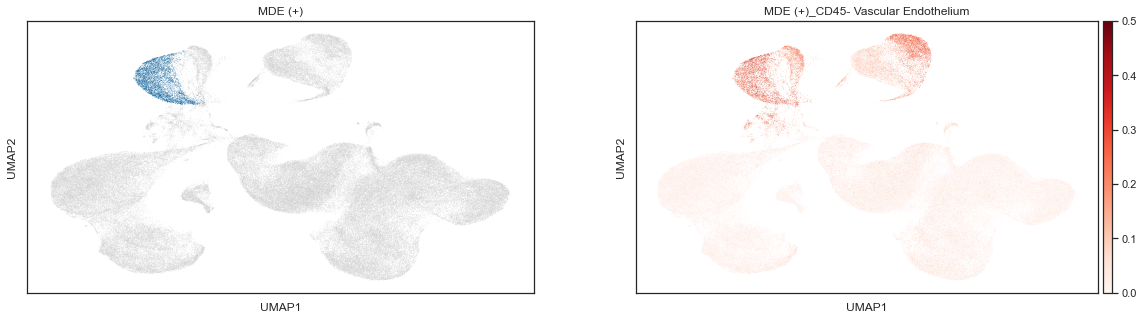

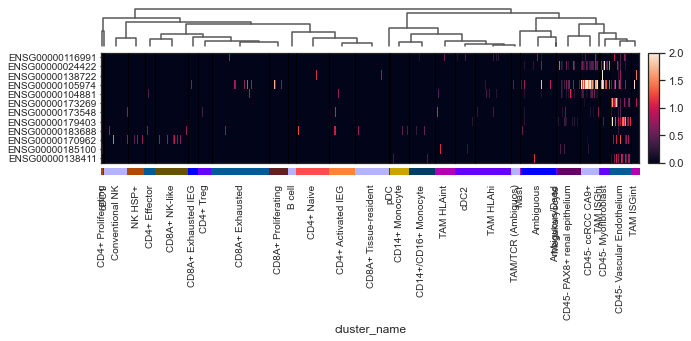

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


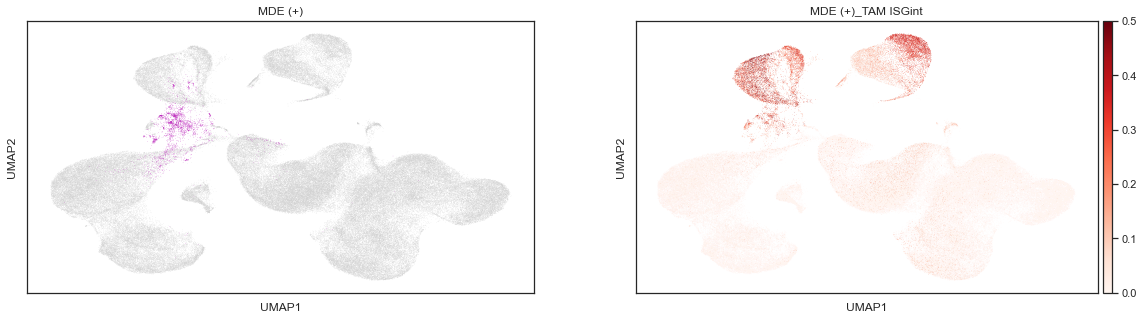

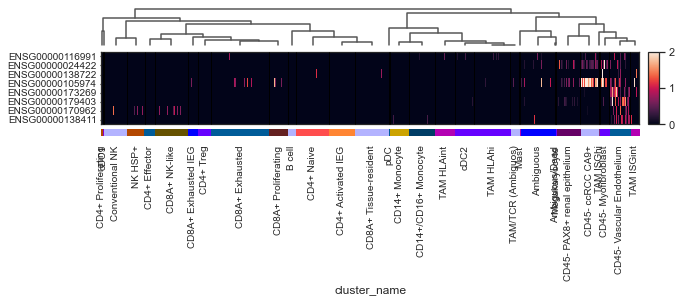

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


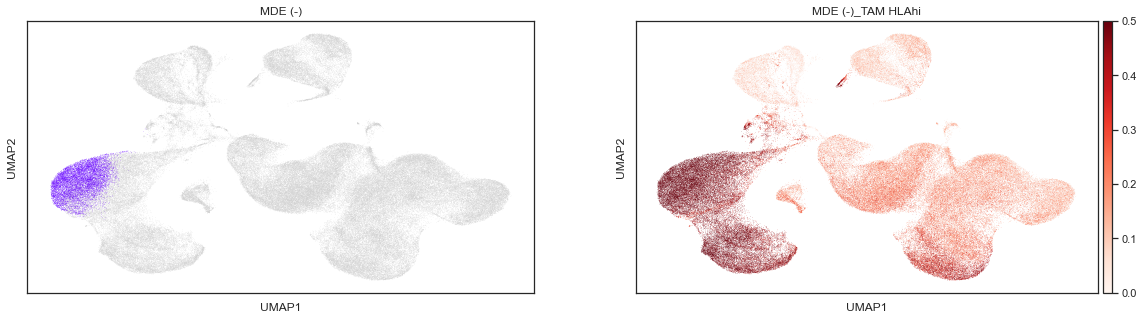

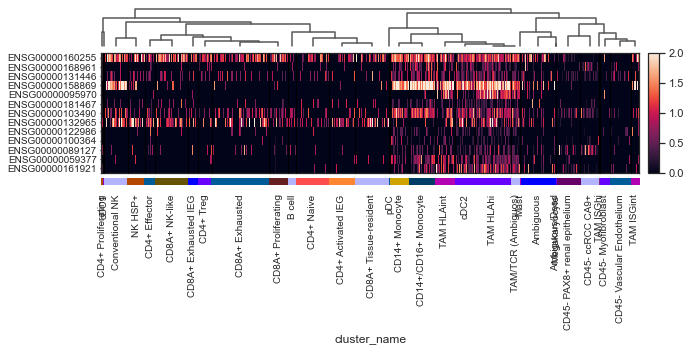

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


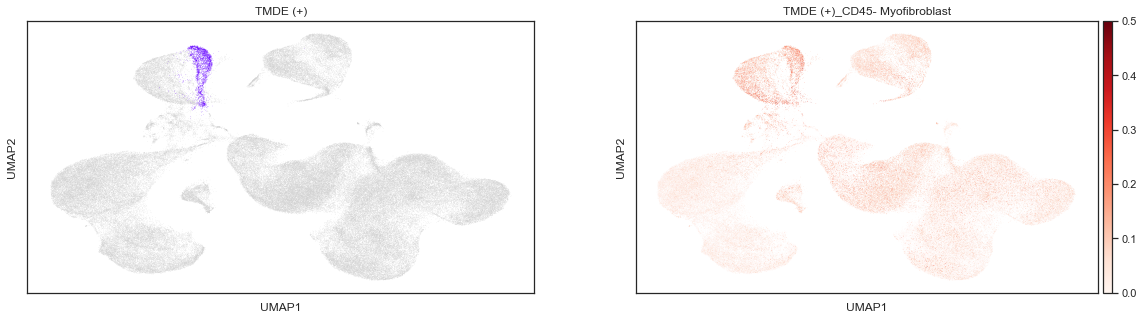

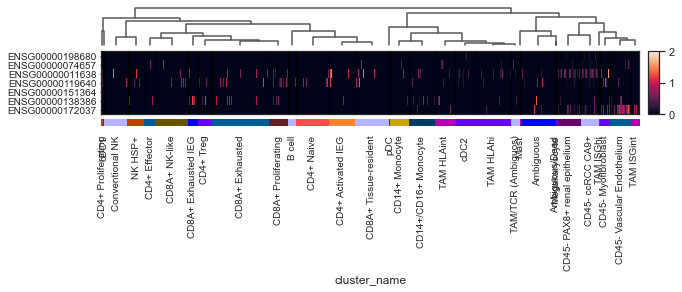

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


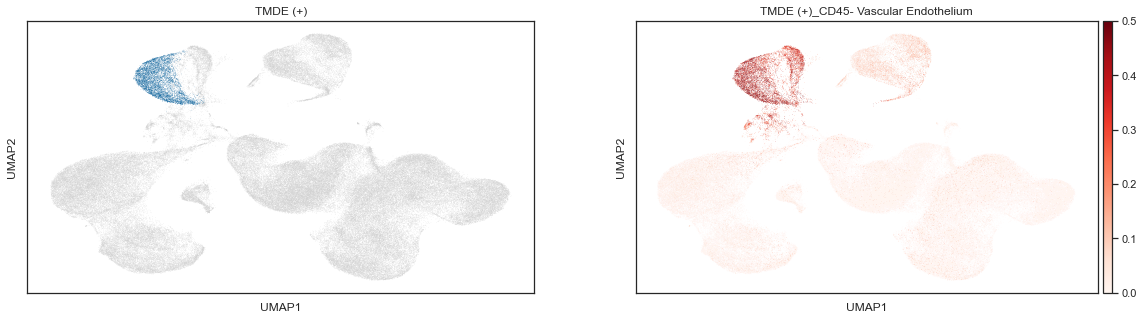

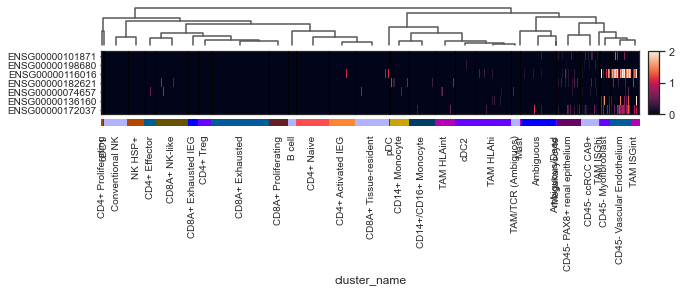

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


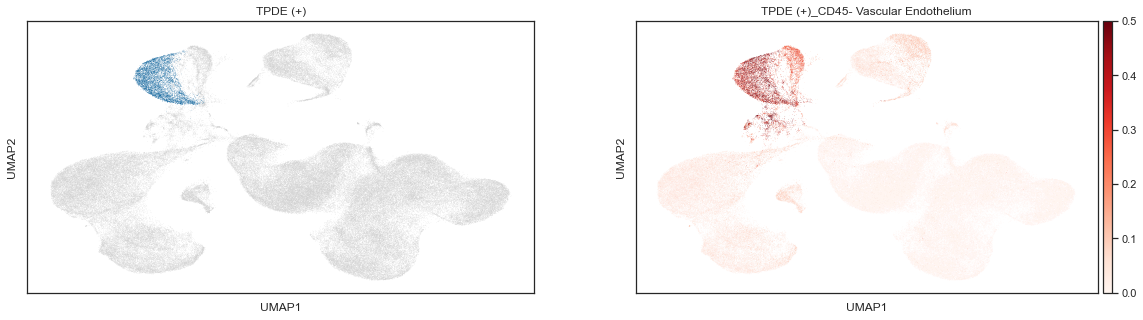

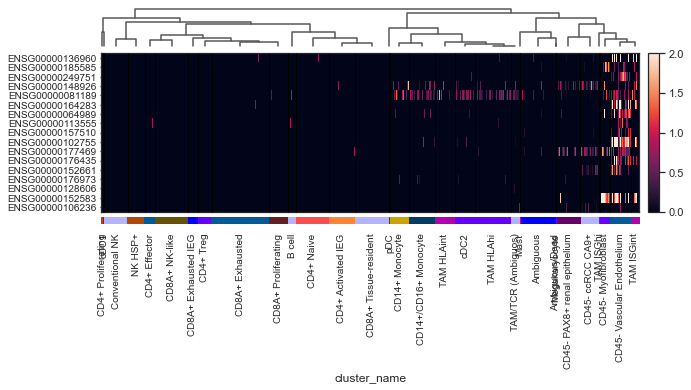

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


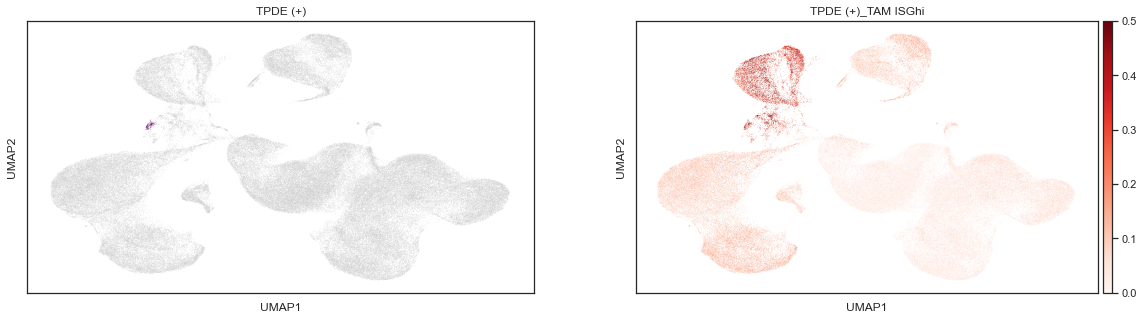

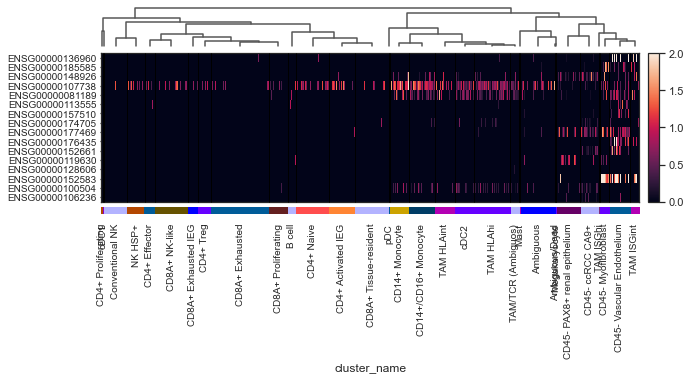

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


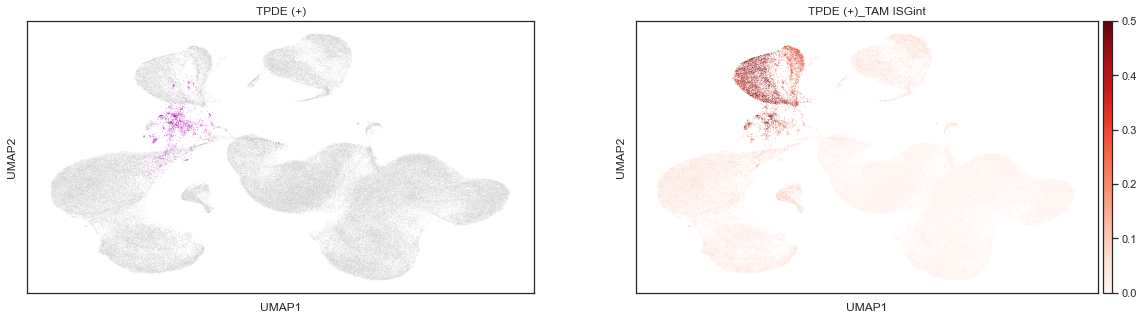

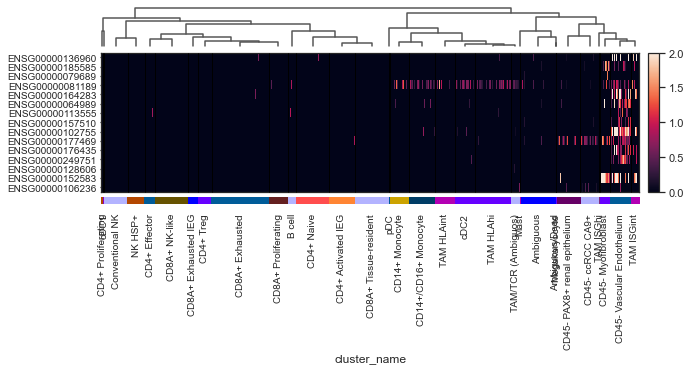

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


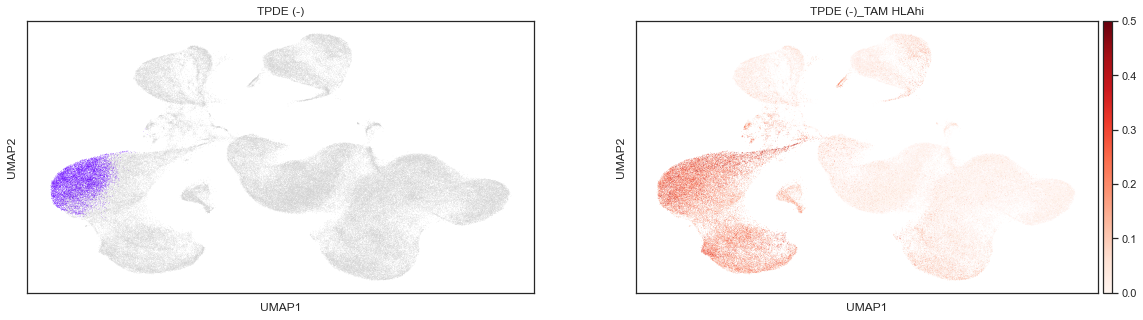

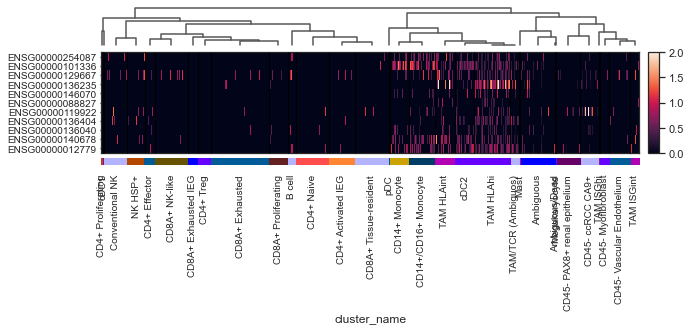

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


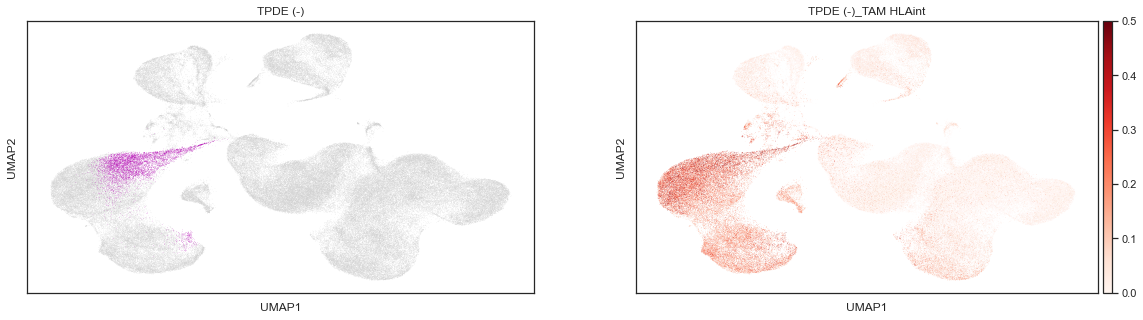

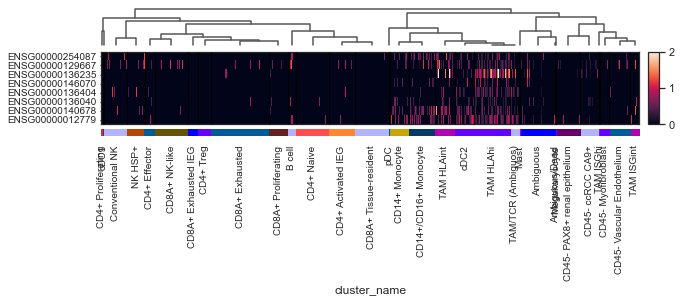

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


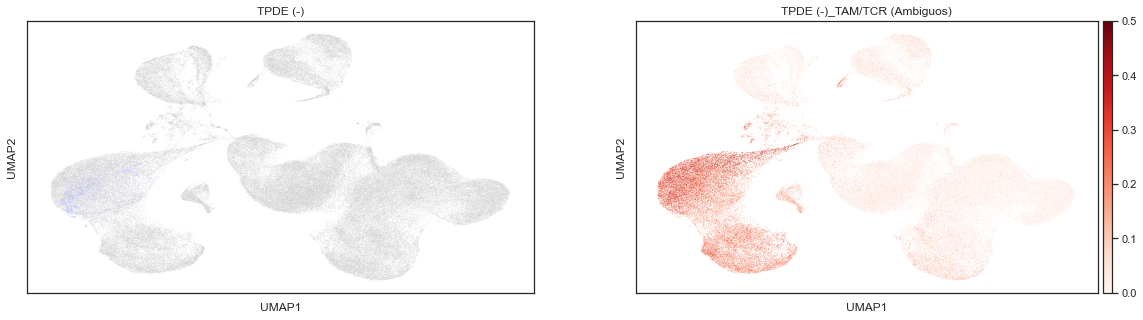

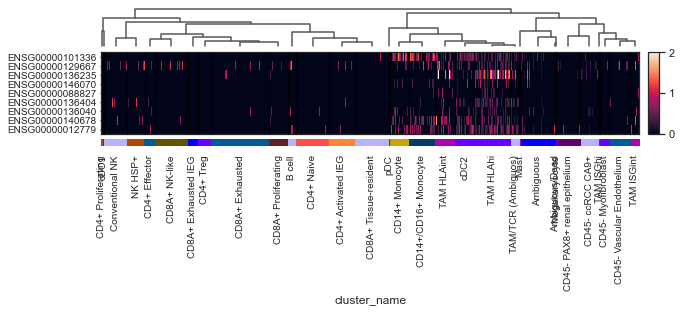

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


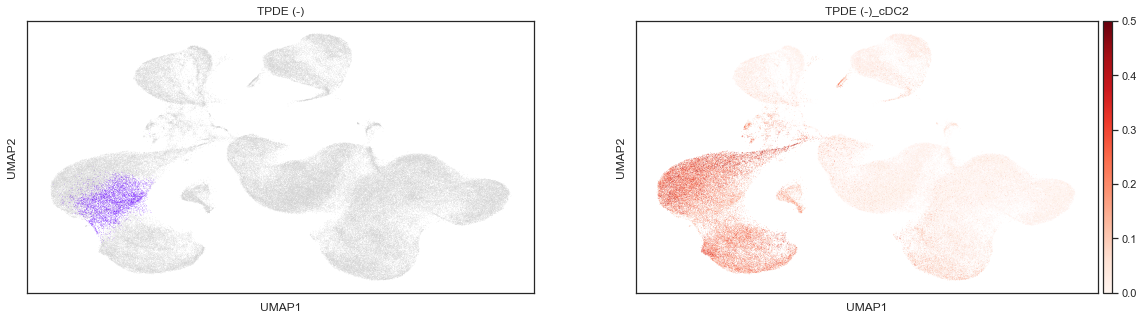

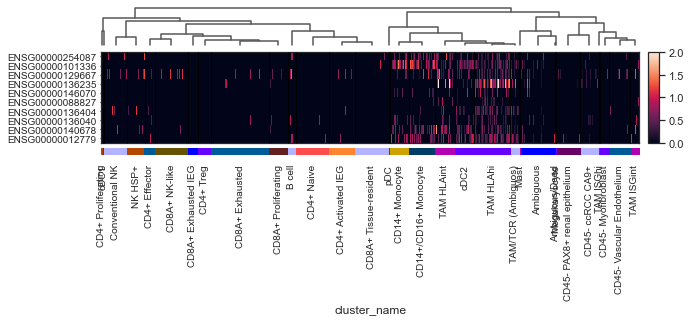

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


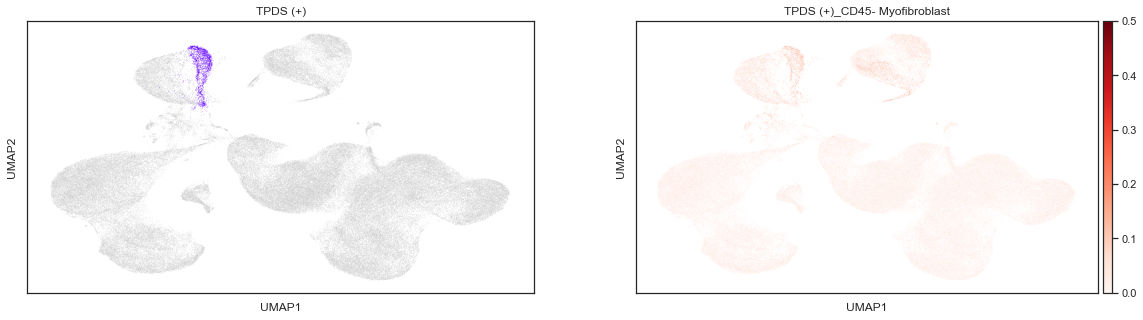

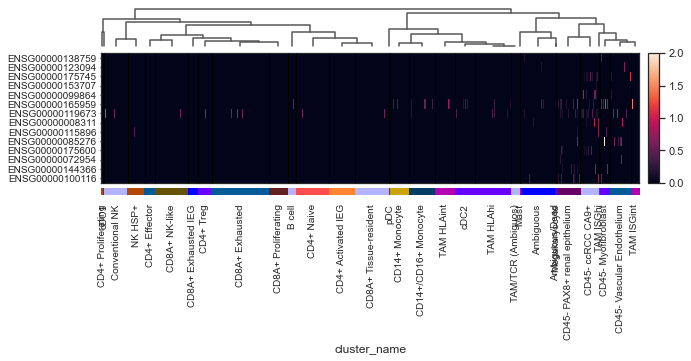

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


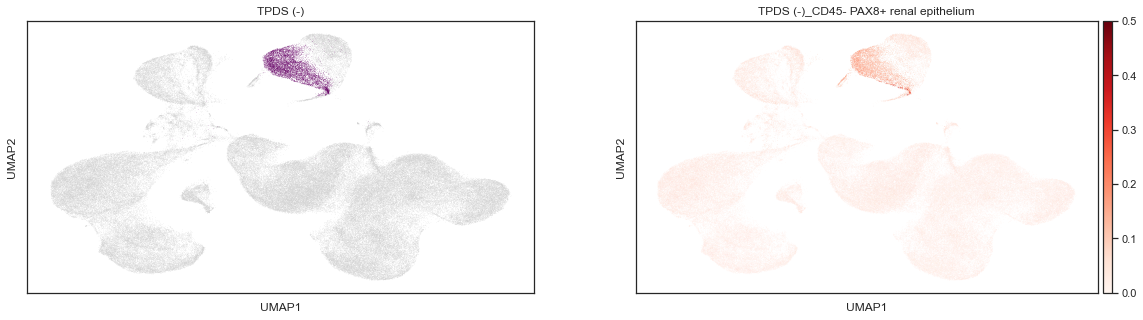

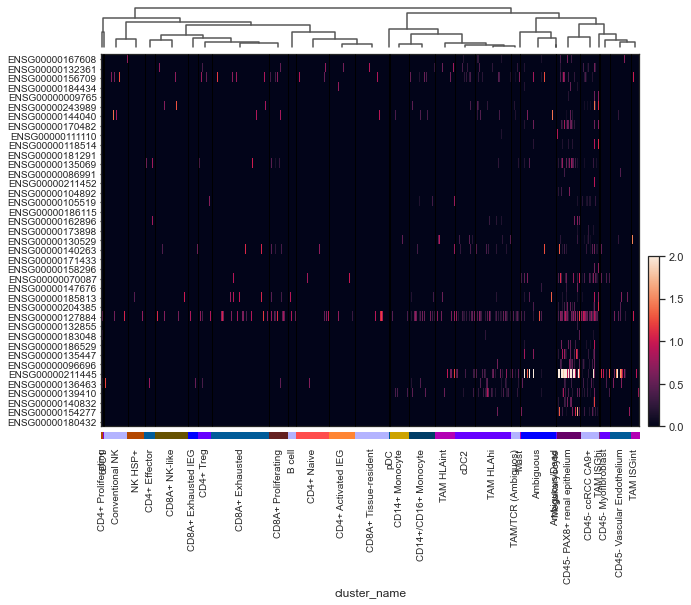

In [29]:
##### Plotting the significant cases
gene_ids = sig_odds_ratio_df['gene_ids'].values
cell_types = sig_odds_ratio_df['Cell type'].values
labels = []
for i, reg_label in enumerate(sig_odds_ratio_df['Regulatory Cluster label'].values):
    genes = gene_ids[i].split(' ')
    mean_expr = np.nanmean(df.loc[genes], axis=0) # Mean expression along the cell types
    data_sub_regulatory.obs[f'{reg_label}_{cell_types[i]}'] = mean_expr
    labels.append(f'{reg_label}_{cell_types[i]}') #Keep track of the labels
    ### Plotting cell type location on umap, scores on umap, and violin plot of scores across cts
    fig, axes = plt.subplots(ncols=2, figsize=(20,5))
    sc.pl.umap(data_sub_regulatory, color='cluster_name',
               groups=[cell_types[i]],
               ax=axes[0], show=False, legend_loc=None)
    axes[0].set_title(reg_label)
    # Get the mean across these genes
    sc.pl.umap(data_sub_regulatory, color=f'{reg_label}_{cell_types[i]}', 
               ax=axes[1], show=True, cmap='Reds', vmin=0, vmax=0.5)    
    sc.pl.heatmap(data_sub_regulatory, var_names=genes, groupby='cluster_name', swap_axes=True,
                 vmin=0, vmax=2.0, dendrogram=True)


## Load in protein data for box plot visualisations

In [30]:
dfs = {}
files = os.listdir(f'{input_data_dir}')
for f in files:
    if 'csv' in f and 'Boxplot_data_' in f:
        d = f.replace('.csv', '').replace('Boxplot_data_', '')
        dfs[d] = pd.read_csv(f'{input_data_dir}{f}')

In [31]:
umap = pd.DataFrame()
umap['UMAP_1'] = data_sub_regulatory.obs['UMAP1']
umap['UMAP_2'] = data_sub_regulatory.obs['UMAP2']

In [32]:
# Now we can iterate through each one and do whatever we need to do
plt.rcParams["figure.figsize"] = (14, 3)
plt.rcParams['svg.fonttype'] = 'none' 
import os
from sciviso import Boxplot

fig_size = (14, 3)
vis_opts = {"figsize": (14, 3), "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

def plot_gene(ensembl_id, cond0, cond1, x="Stage", cmap="Purples", label=''):
    # But I'll just plot a single gene :) 
    # I'll probably just end up plotting the top 3 genes of a certain cluster 
    # that we hopefully can identify co-expression in. (from manual inspection this
    # appears to be the case in some of the clusters)
    gene = df.loc[[ensembl_id]]
    gene_name = gene_map[ensembl_id] # Easier to use the gene name for display
    gene = gene[gene > 0] # Select only those with > 0
    gene = gene.dropna(axis=1)
    plt.rcParams['svg.fonttype'] = 'none' 
    # Make a subplot 
    fig, ax = plt.subplots(nrows=1, ncols=6)
    um = umap.loc[gene.columns]
    ax[0].scatter(um['UMAP_1'].values, um['UMAP_2'].values, c=gene.values, cmap=cmap, s=0.5)#, 
               #vmin=0, vmax=5)
    ax[0].title.set_text(f'{gene_name}')
    ax[0].tick_params(direction='out', length=2, width=1.0)
    ax[0].spines['bottom'].set_linewidth(1.0)
    ax[0].spines['top'].set_linewidth(0)
    ax[0].spines['left'].set_linewidth(1.0)
    ax[0].spines['right'].set_linewidth(0)
    ax[0].tick_params(labelsize=8)
    ax[0].tick_params(axis='x', which='major', pad=2.0)
    ax[0].tick_params(axis='y', which='major', pad=2.0)

    # Do boxplots next to it
    gene = ensembl_id
    box_data_df = dfs['Integrated']
    box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
    gene_data = box_data_df[box_data_df['GeneId'] == gene]
    b = Boxplot(gene_data, x=x, y="values",  add_dots=True, 
            add_stats=True, title=f'Integrated diff.',
            xlabel="Sample", ylabel=f'diff. {cond1}-{cond0}', config=vis_opts)
    b.plot(ax=ax[1], legend=False)

    
    box_data_df = dfs['Protein-LogFC']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'Protein logFC',
                xlabel="Sample", ylabel=f"Protein  {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[2])
    except:
        print('Protein logFC')
        
    box_data_df = dfs['Protein-Tumor']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'Protein Tumor',
                xlabel="Sample", ylabel=f"Protein  {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[3])
    except:
        print('Protein')
        
    box_data_df = dfs['RNA-LogFC']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'RNA logFC',
                xlabel="Sample", ylabel=f"RNA {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[4])
    except:
        print('RNA')
    box_data_df = dfs['CpG-LogFC']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'CpG logFC',
                xlabel="Sample", ylabel=f"CpG {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[5])
    except:
        print('CpG')
    # ALso print the URL so that I can quickly check the ones that look good in protein atlas
    print(f'https://www.proteinatlas.org/{gene}-{gene_name}/pathology/renal+cancer/KIRC')
    fig.suptitle(f'{label} {gene_name} ({cond1}-{cond0})', fontsize=16, fontweight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    
    if save_fig:
        plt.savefig(f'{output_dir}{label}_{gene_name}_{cond1}-{cond0}.svg')
    plt.show()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.176e-03 U_stat=8.100e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.987e-03 U_stat=1.120e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.049e-04 U_stat=9.800e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.222e-02 U_stat=1.190e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.064e-02 U_stat=3.380e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000116016-EPAS1/pathology/renal+cancer/KIRC


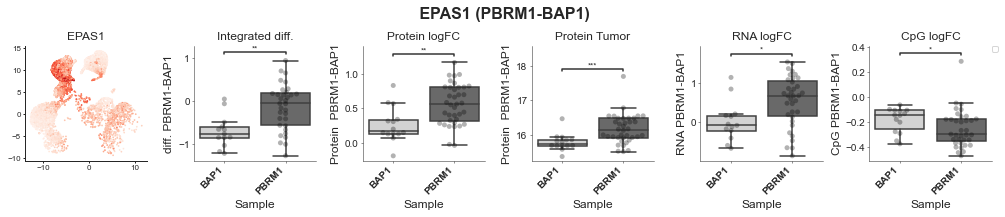

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.022e-01 U_stat=2.820e+02


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 75.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.590e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 75.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.590e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.476e-02 U_stat=3.190e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.657e-03 U_stat=3.660e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000167703-SLC43A2/pathology/renal+cancer/KIRC


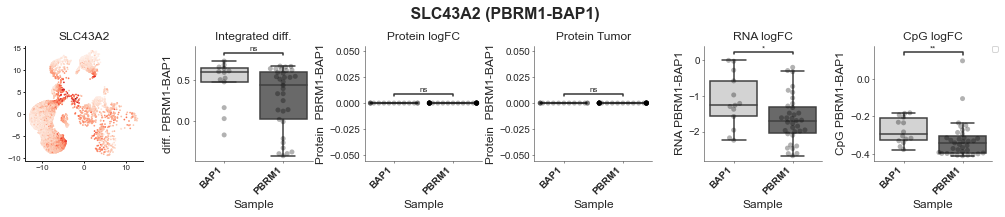

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.747e-01 U_stat=2.380e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.367e-01 U_stat=3.300e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.478e-02 U_stat=3.750e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.261e-01 U_stat=2.320e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.666e-01 U_stat=3.080e+02
https://www.proteinatlas.org/ENSG00000138079-SLC3A1/pathology/renal+cancer/KIRC


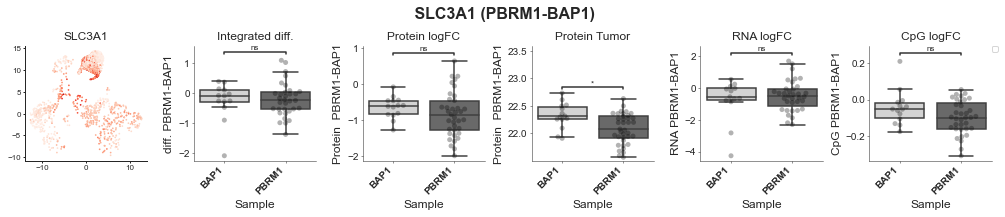

In [33]:
# only plot genes once
from collections import defaultdict
from sciutil import SciUtil
ens_name_map = dict(zip(integrated_df.hgnc_symbol, integrated_df.id))
u = SciUtil()
gene_map = gene_name_map
cond1 = run_label.split('-')[0]
cond0 = run_label.split('-')[1]
for i, gene_name in enumerate(['EPAS1', 'SLC43A2', 'SLC3A1']):
    ensembl_id = ens_name_map[gene_name]
    # NOTE! You'll need to change this to "Mutation" or "Stage" dependning on the comparison
    plot_gene(ensembl_id, cond0, cond1, x=comparison_method, cmap='Reds', label=f'')

## Plot all the genes in one group optionally

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.176e-03 U_stat=8.100e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.367e-01 U_stat=1.880e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.383e-02 U_stat=1.630e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.468e-04 U_stat=6.900e+01


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000136960-ENPP2/pathology/renal+cancer/KIRC


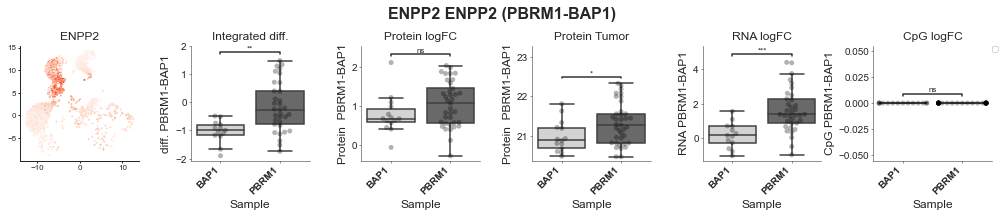

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.656e-03 U_stat=9.800e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.367e-01 U_stat=1.880e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.968e-02 U_stat=1.480e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.597e-04 U_stat=7.600e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.909e-04 U_stat=4.030e+02
https://www.proteinatlas.org/ENSG00000079689-SCGN/pathology/renal+cancer/KIRC


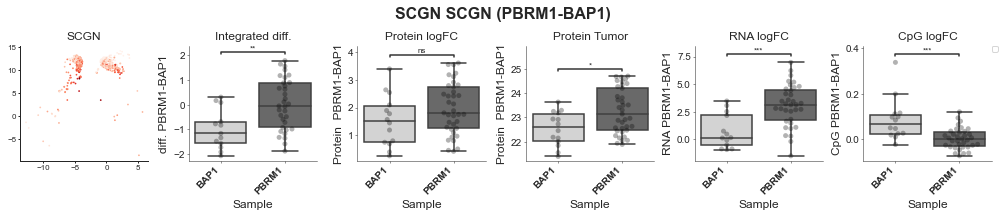

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.918e-03 U_stat=9.200e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.892e-02 U_stat=1.550e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.757e-02 U_stat=1.460e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.766e-03 U_stat=1.080e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000081189-MEF2C/pathology/renal+cancer/KIRC


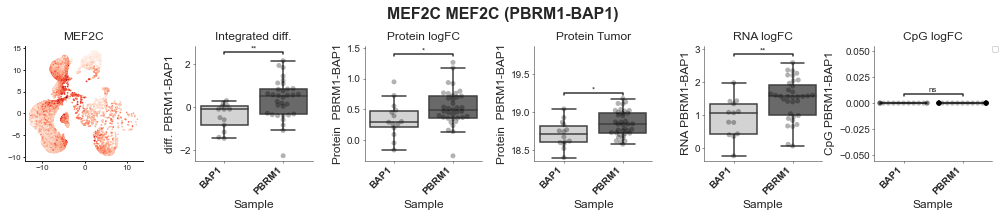

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.024e-03 U_stat=9.900e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.773e-04 U_stat=9.300e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.586e-04 U_stat=9.500e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.593e-02 U_stat=1.310e+02


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000174705-SH3PXD2B/pathology/renal+cancer/KIRC


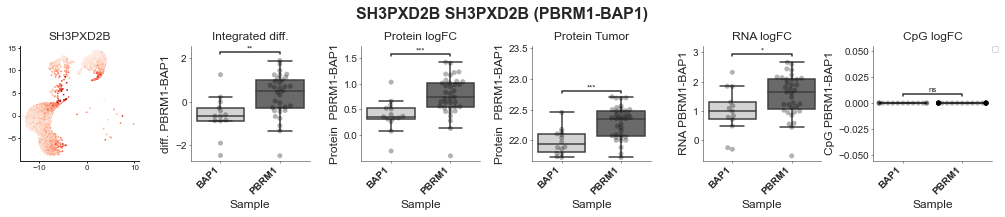

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.311e-04 U_stat=7.700e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.158e-01 U_stat=1.840e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.082e-02 U_stat=1.490e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.956e-04 U_stat=7.900e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.850e-02 U_stat=3.250e+02
https://www.proteinatlas.org/ENSG00000102755-FLT1/pathology/renal+cancer/KIRC


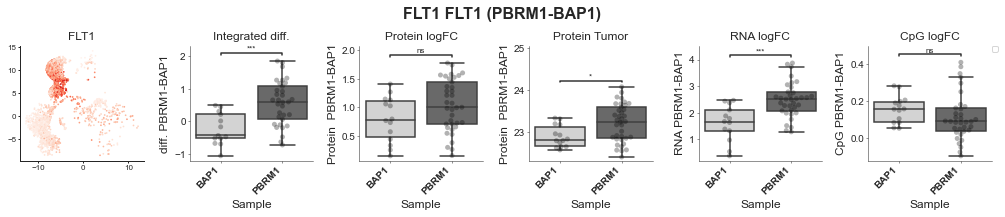

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.918e-03 U_stat=9.200e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.770e-01 U_stat=2.070e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.477e-02 U_stat=1.710e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.863e-04 U_stat=8.500e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000176973-FAM89B/pathology/renal+cancer/KIRC


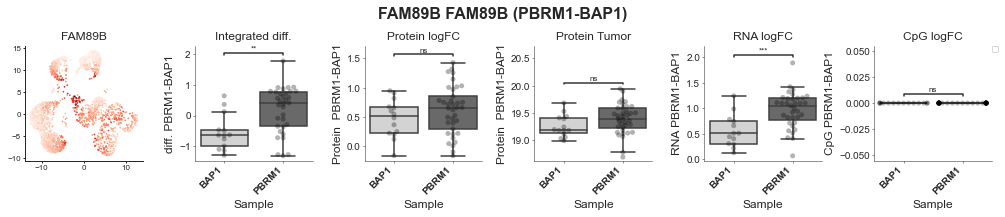

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.792e-03 U_stat=8.600e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.734e-01 U_stat=1.940e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.652e-01 U_stat=2.380e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.710e-04 U_stat=6.500e+01


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000119630-PGF/pathology/renal+cancer/KIRC


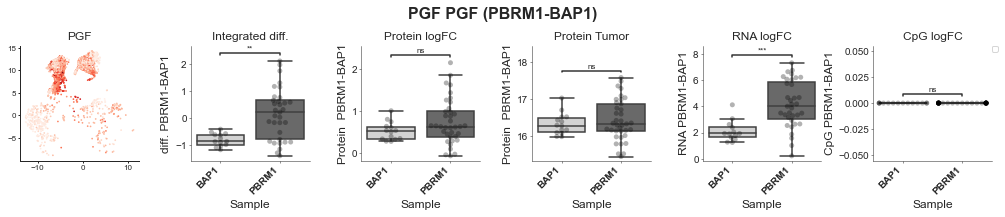

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.158e-03 U_stat=9.300e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.609e-02 U_stat=1.640e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.217e-02 U_stat=1.570e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.080e-04 U_stat=8.400e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.207e-01 U_stat=2.400e+02
https://www.proteinatlas.org/ENSG00000152583-SPARCL1/pathology/renal+cancer/KIRC


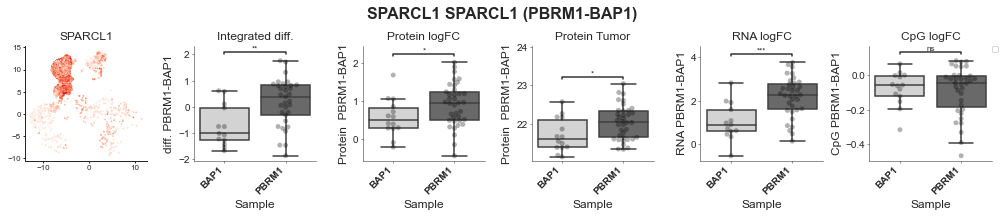

In [34]:
# only plot genes once
from collections import defaultdict
from sciutil import SciUtil

u = SciUtil()
cond1 = run_label.split('-')[0]
cond0 = run_label.split('-')[1]

to_plots = ['TPDE (+)']
gene_map = gene_name_map
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in to_plots:
    genes = plotting_gene_map[cat]
    gene_names = []
    gene_names = [gene_name_map.get(g) for g in genes]
    p_vals = [gene_padj_map.get(g) for g in genes]
    for i, ensembl_id in enumerate(genes):
        plot_gene(ensembl_id, cond0, cond1, x=comparison_method, cmap='Reds', label=f'{gene_names[i]}')

## Finally use the enrichment boxplots from scanpy

categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: TPDE (-), TPDE (+)


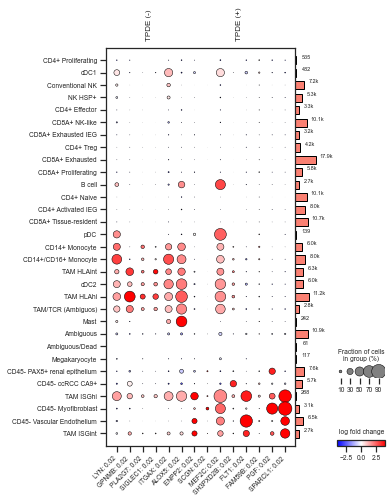

In [35]:
categories_order={'TPDE': ['TPDE (-)', 'TPDE (+)']}

# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in categories_order:
    fig, ax = plt.subplots(figsize=(5,8))
    plt_plotting_gene_map = {k:plotting_gene_map[k] for k in categories_order[cat]}

    dpl = sc.pl.rank_genes_groups_dotplot(
        data_sub_regulatory,
        var_names=plt_plotting_gene_map,
        values_to_plot="logfoldchanges",
        cmap='bwr',
        vmin=-4,
        vmax=4,
        min_logfoldchange=3,
        colorbar_title='log fold change',
        show = False, 
        ax=ax,
        return_fig=True
    )
    dpl.add_totals().style(dot_edge_color='black', cmap='bwr', dot_edge_lw=0.5)

    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

    # Rename the ensembl gene IDs to the gene name 
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_genes.svg')
    plt.show()


categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: MDS (+), MDE (+), TMDE (+), etc.


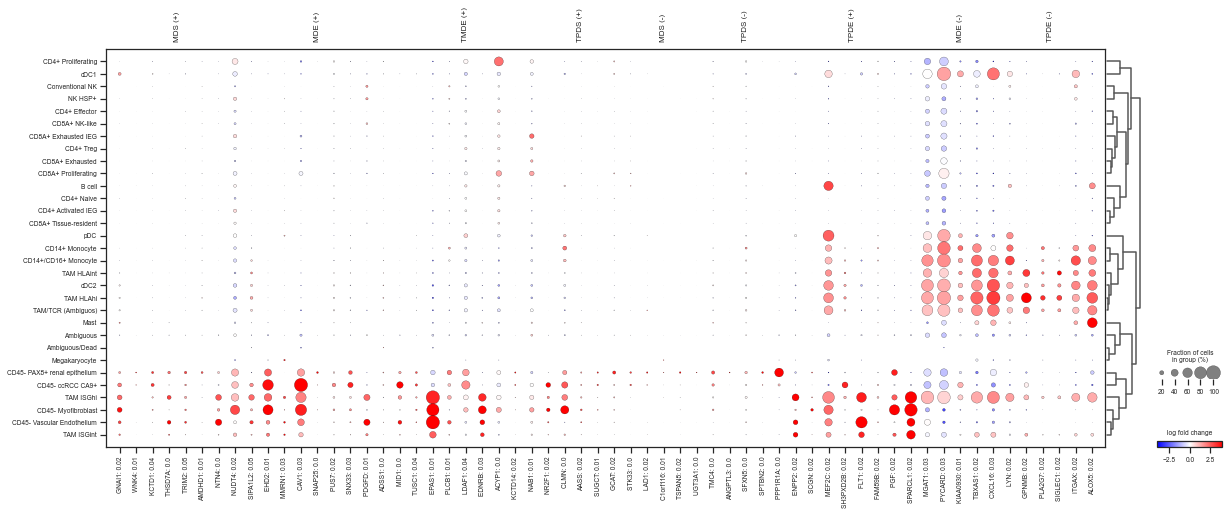

categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: B cell, CD4+ Naive, CD4+ Proliferating, etc.


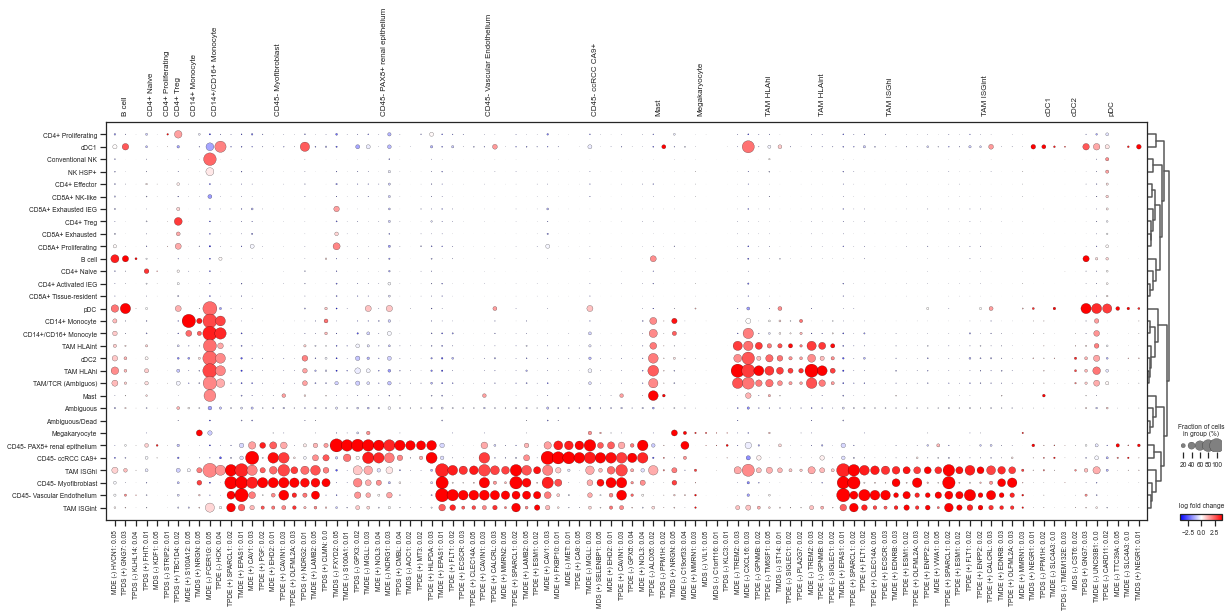

In [36]:
# Plot everything
fig, ax = plt.subplots(figsize=(20,8))
dpl = sc.pl.rank_genes_groups_dotplot(
    data_sub_regulatory, # This is the ranking we created earlier
    var_names=plotting_gene_map,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
    show = False, 
    ax=ax,
    return_fig=True
)
ax_all = dpl.get_axes()
ax = ax_all['mainplot_ax']
# Rename to gene names
labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
# Rename the ensembl gene IDs to the gene name 
if save_fig:
    plt.savefig(f'{output_dir}{run_label}_rank_cell-types.svg')
plt.show()

# Another version this time not ordered by the Regulatory clusters 
fig, ax = plt.subplots(figsize=(20,8))
dpl = sc.pl.rank_genes_groups_dotplot(
    data_sub_regulatory,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
    show = False, 
    ax=ax,
    return_fig=True
)
ax_all = dpl.get_axes()
ax = ax_all['mainplot_ax']
# Rename to gene names
labels = [f'{gene_cluster_map.get(item.get_text())} {gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
# Rename the ensembl gene IDs to the gene name 
if save_fig:
    plt.savefig(f'{output_dir}{run_label}_rank_cell-types.svg')
plt.show()


categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: TPDE (+), TPDS (-), TPDS (+)


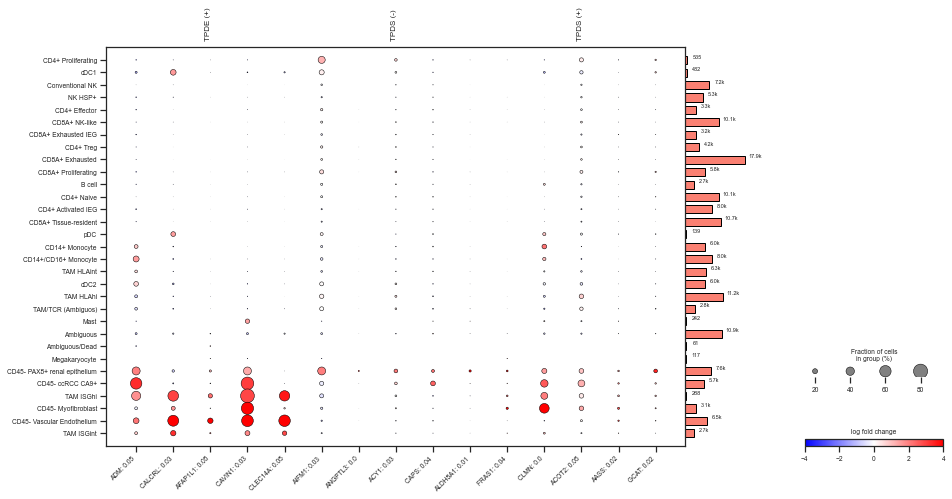

In [37]:
categories_order={'TPDE': ['TPDE (+)', 'TPDS (-)', 'TPDS (+)']}
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in categories_order:
    fig, ax = plt.subplots(figsize=(15,8))
    plt_plotting_gene_map = {k:plotting_gene_map_cell[k] for k in categories_order[cat]}
    dpl = sc.pl.rank_genes_groups_dotplot(
        data_sub_regulatory,
        var_names=plt_plotting_gene_map,
        values_to_plot="logfoldchanges",
        cmap='bwr',
        vmin=-4,
        vmax=4,
        min_logfoldchange=3,
        colorbar_title='log fold change',
        show = False, 
        ax=ax,
        return_fig=True
    )
    dpl.add_totals().style(dot_edge_color='black', cmap='bwr', dot_edge_lw=0.5)

    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

    # Rename the ensembl gene IDs to the gene name 
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_rank_genes.svg')
    plt.show()


In [38]:
# Make a square dataframe based on the odds ratio
cluster_labels = new_df['RegulatoryCluster'].unique()

# Let's get an ordered dict of the values so that we can use them later
plotting_gene_map_cell = defaultdict(list) # Get the sig ones since we don't want to plot all!
for cluster in cluster_labels:
    r_df = new_df[new_df['RegulatoryCluster'] == cluster]
    if len(r_df) > 0:
        gene_to_value = {}
        for i, gene in enumerate(r_df.index.values):
            for column in r_df:
                gene_to_value[gene] = r_df[column].values[i]
        # Sort gene_to_value
        gene_to_value_sorted = dict(sorted(gene_to_value.items(), key=lambda item: item[1]))
        # Get the genes for each of the cell types
        plotting_gene_map_cell[cluster] += list(gene_to_value_sorted.keys())[:5]
    else:
        values.append(0)
# Make sure there weren't any duplicates
for c in plotting_gene_map_cell:
    plotting_gene_map_cell[c] = list(set(plotting_gene_map_cell[c]))

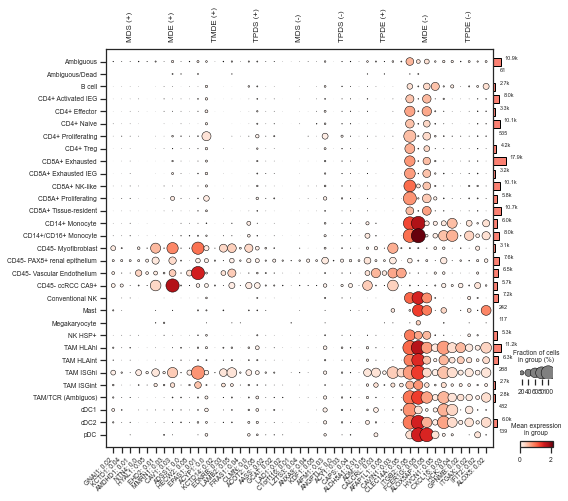

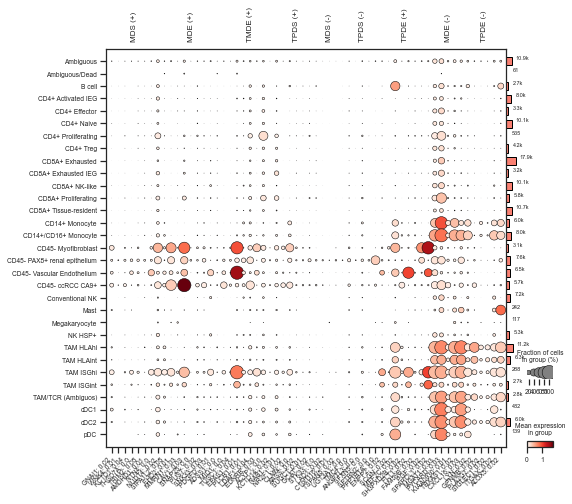

In [39]:
categories_order={'All': list(plotting_gene_map.keys())}
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in categories_order:
    fig, ax = plt.subplots(figsize=(8,8))
    plt_plotting_gene_map = {k:plotting_gene_map_cell[k] for k in categories_order[cat]}

    dpl = sc.pl.dotplot(
        data_sub_regulatory,
        var_names=plt_plotting_gene_map,
        cmap='Reds',
        ax=ax,
        swap_axes=False,
        groupby='cluster_name',
        return_fig=True
    )
    dpl.add_totals().style(dot_edge_color='black', cmap='Reds', dot_edge_lw=0.5)

    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

    # Rename the ensembl gene IDs to the gene name 
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_genes.svg')
    plt.show()

# Do a different ordering if we want
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in categories_order:
    fig, ax = plt.subplots(figsize=(8,8))
    plt_plotting_gene_map = {k:plotting_gene_map[k] for k in categories_order[cat]}

    dpl = sc.pl.dotplot(
        data_sub_regulatory,
        var_names=plt_plotting_gene_map,
        cmap='Reds',
        ax=ax,
        swap_axes=False,
        groupby='cluster_name',
        return_fig=True
    )
    dpl.add_totals().style(dot_edge_color='black', cmap='Reds', dot_edge_lw=0.5)

    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

    # Rename the ensembl gene IDs to the gene name 
    if save_fig:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_genes.svg')
    plt.show()
